In [1]:
# Characterizing Link Channel Impulse Response on POWDER

# Authors (alphabetical order):
# - Cassie Jeng
# - Neal Patwari
# - Aarti Singh
# - Jie Wang
# - Meles Gebreyesus Weldegebriel

# February 2025, Version 0.2

# This python notebook provides code to generate an IQ file with PN codes that can be transmitted between 
# nodes on POWDER using the Shout framework and shows the channel impulse response and multipath resulting 
# from cross-correlating the filtered received signal with the original PN code packet.

In [2]:
# Standard packages
import argparse
import sys
import os
import subprocess
import json
import datetime

# IQ Generation packages
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter

# PN Generation packages
# !pip install pylfsr
import pylfsr
from pylfsr import LFSR

# Other packages
import itertools
import scipy.io as sio
from scipy import signal, stats
from scipy.signal import find_peaks
import h5py
from matplotlib import rc
rc('xtick',labelsize=14)
rc('ytick',labelsize=14)

In [3]:
# 1. Create an IQ file from PN codes

# IQ Generation functions

# PURPOSE: Create QPSK bits for transmit
# INPUT: inphase and quadrature bits
# OUTPUT: QPSK_bits to transmit
def Information_Transmit_r(inphase, quad):
    in_phase = np.asarray(inphase)
    quadrature = np.asarray(quad)
    QPSK_bits = np.vstack([in_phase, quadrature])
    return QPSK_bits

# PURPOSE: List allowed PN taps based on specified number of stages
# INPUT: N_stages between 7 and 11
# OUTPUT: L_codelen PN code length, ptaps allowed taps
def choose_taps(N_stages):
    L_codelen = (2 ** N_stages) - 1
    if N_stages == 7:
        ptaps = '[7,6] [7,3] [7,1]'
    elif N_stages == 8:
        ptaps = '[8,6,5,4] [8,6,5,3]'
    elif N_stages == 9:
        ptaps = '[9,5] [9,6,4,3]'
    elif N_stages == 10:
        ptaps = '[10,7] [10,3]'
    elif N_stages == 11:
        ptaps = '[11,9] [11,8,5,2]'
    elif N_stages == 12:
        ptaps = '[12,6,4,1]'
    elif N_stages == 13:
        ptaps = '[13,4,3,1]'
    elif N_stages == 14:
        ptaps = '[14,5,3,1]'
    else:
        ptaps = ''
    return L_codelen, ptaps

# PURPOSE: Convert input data to signal space values
# INPUT: data bits, inputVec, outputVec coding
# OUTPUT: output values from outputVec
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('ERROR in function lut: Input and Output vectors must have identical length')
        exit()
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: Insert 0's between samples to oversample at OS_Rate
# INPUT: x data to oversample, OS_Rate rate to sample
# OUTPUT: x_s oversampled data
def oversample(x, OS_Rate):
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

# PURPOSE: Create a Square Root Raised Cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse shape for SRRC
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    ntemp = list(range(-N*Lp, N*Lp+1))
    n = []
    for each in ntemp:
        n.append(each + math.pow(10,-9))
    # Plug into time domain formula for the SRRC pulse shape
    h = []
    coeff = 1/math.sqrt(N)
    for each in n:
        sine_term = math.sin(math.pi * each * (1-alpha) / N)
        cosine_term = math.cos(math.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = math.pi * each / N
        denom_part = 1 - math.pow(cosine_coeff, 2)
        denominator = denom_coeff * denom_part
        pulse = coeff * numerator / denominator
        h.append(pulse)
    return h

# PURPOSE: Open filename and write array to it as binary
# INPUT: data to write as binary, filename to write to
# OUTPUT: file with complex binary data
def write_complex_binary(data, filename):
    # Open filename and write array to it as binary, format is interleaved float IQ
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)

# PURPOSE: Load samples from binary file
# INPUT: filename to load complex binary from
# OUTPUT: samps from file
def get_samps_from_file(filename):
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype= np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ
    return samps

# PN code generation

samples_per_chip = 2
samp_rate = 56000000.0
#samp_rate = 250000.0
alpha = 0.75
A = math.sqrt(9/2)
Lp = 6

N_stages = 14
L_codelen, ptaps = choose_taps(N_stages)
print('Code length L = ' + str(L_codelen))
print('Valid taps to choose: ' + ptaps)

# PN code generation

# In-Phase Sequence
state = '0,0,0,0,0,0,0,0,0,0,0,1,0,0'
taps = '14,5,3,1'

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_iSeq = L.getFullPeriod()

# Quadrature Sequence
state = '0,0,0,0,0,0,0,0,1,0,0,0,0,0'
taps = '14,5,3,1'

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_qSeq = L.getFullPeriod()

Frame = Information_Transmit_r(pn_iSeq, pn_qSeq)

# Modulation
# INPUT: data
# OUTPUT: modulated values, x
xI_list = []
for each in Frame[0]:
    if each == 0:
        xI_list.append(-1)
    else:
        xI_list.append(1)

xQ_list = []
for each in Frame[1]:
    if each == 0:
        xQ_list.append(-1) # -1j
    else:
        xQ_list.append(1) # 1j
xI_list_new = [i * A for i in xI_list]
xQ_list_new = [i * A for i in xQ_list]

xI = np.array(xI_list_new)
xQ = np.array(xQ_list_new)

xI = xI.reshape((1,len(Frame[0])))
xQ = xQ.reshape((1,len(Frame[1])))

# Oversample
# INPUT: modulated values, x
# OUTPUT: modulated values at sampling rate, samples_per_chip
x_s_I = oversample(xI,samples_per_chip)
x_s_Q = oversample(xQ,samples_per_chip)

pulse = SRRC(alpha,samples_per_chip,Lp)
pulse = np.array(pulse)
pulse = np.reshape(pulse,pulse.size)

x_s_I = np.reshape(x_s_I, x_s_I.size)
x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
s_0_I = np.convolve(x_s_I, pulse, mode='full')
s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

QPSK_samples = s_0_I

# Normalize PN code to Unit Energy
En = sum([x**2 for x in QPSK_samples])
print('PN Code Energy: ' + str(En))
QPSK_samples = QPSK_samples / math.sqrt(En)
print('Unit PN Code Energy: ' + str(sum([x**2 for x in QPSK_samples])))

# Transmit 3 copies of PN code packet
numPN = 3
P = len(pulse)-1
P2 = int(P/2)
oversample_PNlen = samples_per_chip*L_codelen
QPSK_samples_add = np.zeros((oversample_PNlen*numPN)+P, dtype=type(QPSK_samples[0]))

for i in range(numPN):
    QPSK_samples_add[i*oversample_PNlen:(i*oversample_PNlen)+oversample_PNlen+P] += QPSK_samples

QPSK_samples_Final = np.hstack([np.zeros(1024, dtype=type(QPSK_samples[0])),QPSK_samples_add])

# Calculate period T for single PN code
# periodT = (samples_per_chip * (1 / samp_rate) * L_codelen) * 1000000
# periodT = periodT / 2.0
# print('PN Code Period T = ' + str(periodT) + ' us')

# WATCH local offset adjustments
node_offsets = '{"cnode-ebc-dd-b210": 0.0, "cnode-guesthouse-dd-b210": 87.5146, "cnode-mario-dd-b210": -22.615, "cnode-moran-dd-b210": -104.046, "cnode-ustar-dd-b210": -24.532}'
node_offset_dict = json.loads(node_offsets)
# print(node_offset_dict["cnode-guesthouse-dd-b210"])

Code length L = 16383
Valid taps to choose: [14,5,3,1]
PN Code Energy: 73722.35906186147
Unit PN Code Energy: 1.000000000000007


In [4]:
# 3. Cross-Correlation and Channel Impulse Response from Collected Data

# Reading data functions

# PURPOSE: Get data and time from timestamp
# INPUT: timestamp
# OUTPUT: data and time, example: 01-04-2023, 19:50:27
def get_time_string(timestamp):
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

# PURPOSE: Load parameters from the saved json file
# INPUT: data folder, saved json_file
# OUTPUT: experiment specifications from json file
def JsonLoad(folder, json_file):
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']
    return rxrepeat, rxrate, txnodes, rxnodes

# PURPOSE: Load data from hdf5 format measurement file
# INPUT: meas_folder path to measurement folder
# OUTPUT: data, noise, and txrxloc node names
def traverse_dataset(meas_folder):
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r")
    for cmd in dataset.keys():
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            samplesNotx = dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))
        else:
            print('Unsupported command: ', cmd)
    return data, noise, txrxloc

In [5]:
# Access JSON information

folder = 'Dense-Deployment_Shout_meas_02-18-2025_11-38-19'

jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
print('txlocs:')
print(txlocs)
print('\nrxlocs:')
print(rxlocs)

# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)

rx_names = []
for rxl in rxlocs:
    rx_names.append(rxl.split('-')[1])

rx_names = sorted(rx_names)

tx_names = []
for txl in txlocs:
    tx_names.append(txl.split('-')[1])

tx_names = sorted(tx_names)

txlocs:
['cnode-ebc-dd-b210', 'cnode-mario-dd-b210', 'cnode-ustar-dd-b210', 'cnode-guesthouse-dd-b210', 'cnode-moran-dd-b210']

rxlocs:
['cnode-ebc-dd-b210', 'cnode-mario-dd-b210', 'cnode-ustar-dd-b210', 'cnode-guesthouse-dd-b210', 'cnode-moran-dd-b210']


In [6]:
# CIR functions

# PURPOSE: Cross-correlate received signal with transmitted signal.
#          Highest amplitude corresponds to the index delay where the
#          transmitted packet is found in the received packet.
# INPUT: rx0 received signal, packetSignal transmitted PN code packet
# OUTPUT: lagIndex highest correlation delay index, lags, xcorr_mag, peak
def crossCorrelationMax(rx0, packetSignal):
    # Cross correlate with the original packet to find it in the noisy signal
    lags = signal.correlation_lags(len(rx0), len(packetSignal), mode='same')
    xcorr_out = signal.correlate(rx0, packetSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)

    length_of_packet = len(packetSignal)
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    peak = lags[np.argmax(xcorr_mag)]

#     plt.figure()
#     plt.plot(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
#     plt.legend(loc='upper right')
#     plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
#     plt.xlabel(r'Time ($\mu$s)', fontsize=14)
#     plt.tight_layout()
#     plt.show()

    return lagIndex, lags, xcorr_mag, peak

# PURPOSE: Convert samples to microseconds
# INPUT: value in samples
# OUTPUT: time value in microseconds (us)
def samples_to_us(value, samp_rate):
    return (float)((value/samp_rate)*1000000)

In [7]:
# JSON of RT CIR with correct heights, more allowed reflections, more samples collected (more tx signals sent)
# "tx-rx": [f_rttau, f_rta]
# rt_results_dict = {}
# rt_json = json.loads(json.dumps(rt_results_dict))

# rt_json_filename = 'RTcir_rt_nheight.json'
# rt_json_filename = 'RTcir_rt.json'
# rt_json_filename = 'RTcir_dd.json'
rt_json_filename = 'RTcir_dd_diff.json'

with open(rt_json_filename, 'r') as jsonfile:
    rt_json = json.load(jsonfile)[0]


 ----- PLOTNUM: 0, TX: cnode-ebc-dd-b210, RX: cnode-mario-dd-b210 ----- 

ebc-mario
RX Time Delay: -33.0 us
Amplitude matching adjustment ratio [xcorr/RT]: 1.7453554195582988
fig_num: 1


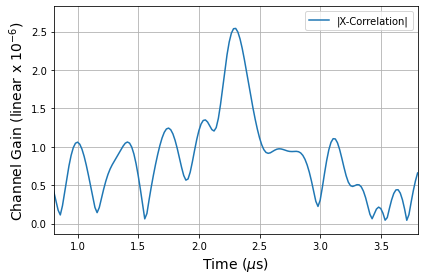

fig_num: 2


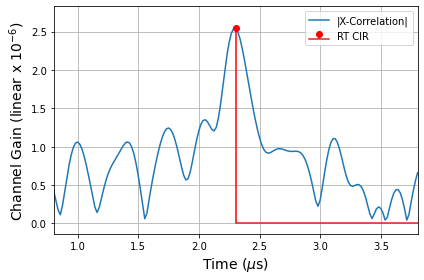

Count of measured local CIR peaks (pre-peak bucket): 3
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 3
fig_num: 3


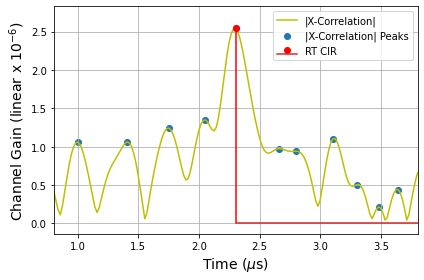

fig_num: 4


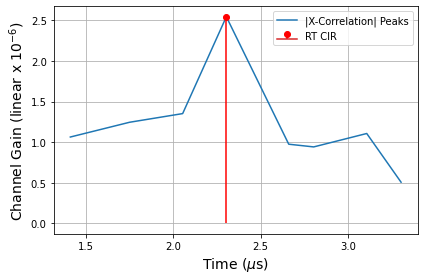

-- Total Received Power --
RT: 6.4648528990562495 W
CIR (local peaks): 14.28939132441807 W
CIR (full): 45659.83061608853 W
[1.41072886 1.75001457 2.053586   2.303586   2.66072886 2.803586
 3.10715743 3.303586  ]

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.448532083112326 us
noise_std threshold: 1.8826778229296726
Number of total RT multipath: 7
Number of Non-matching RT multipath: 10
Number of RT multipath close in time (ns): 0
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/3 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/3 --> 0.0% match rate

 ----- PLOTNUM: 1, TX: cnode-ebc-dd-b210, RX: cnode-ustar-dd-b210 ----- 

ebc-ustar
RX Time Delay: -22.982142857142858 us
Amplitude matching adjustment ratio [xcorr/RT]: 10.965483448081798
fig_num: 5


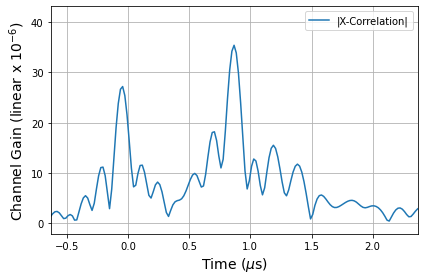

fig_num: 6


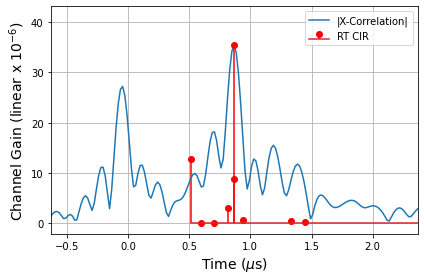

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 5
fig_num: 7


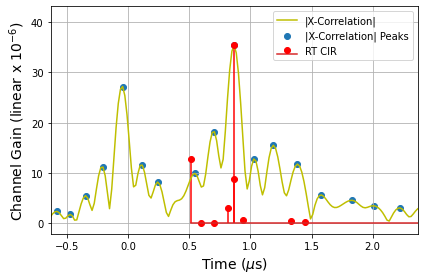

fig_num: 8


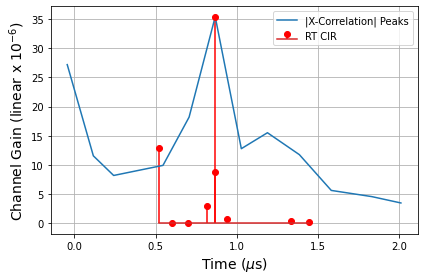

-- Total Received Power --
RT: 1504.7375313109978 W
CIR (local peaks): 3231.2303759921997 W
CIR (full): 179769.9523692348 W
[-0.04385875  0.11685554  0.24185554  0.54542697  0.70614125  0.86685554
  1.02756983  1.18828411  1.38471268  1.58114125  1.83114125  2.00971268]

-- RMS Delay Spread --
RT: 0.1091826581647047 us
CIR (local peaks): 0.46998147310675414 us
noise_std threshold: 4.278824530382903
RT CIR at 0.5180415399999951 us is 27.385428571431447 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.941
Scaled RT CIR amplitude: 12.847

MATCH
fig_num: 9


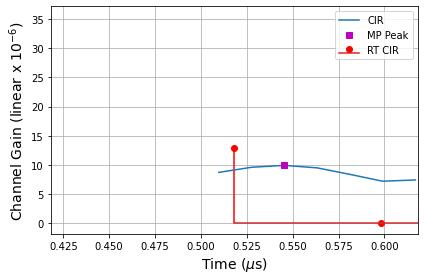

RT CIR at 0.8668555399999995 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 35.379

MATCH
fig_num: 10


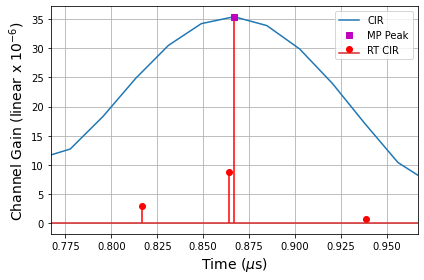

RT CIR at 0.7010215400000099 us is 5.119714285704902 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 18.201
Scaled RT CIR amplitude: 0.105
fig_num: 11


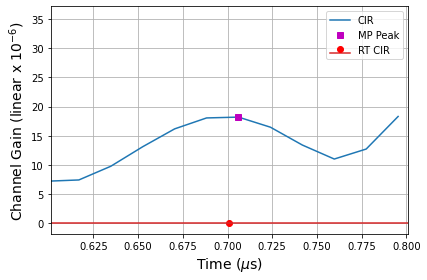

RT CIR at 1.4466815400000108 us is 61.968857142865374 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 11.777
Scaled RT CIR amplitude: 0.22
fig_num: 12


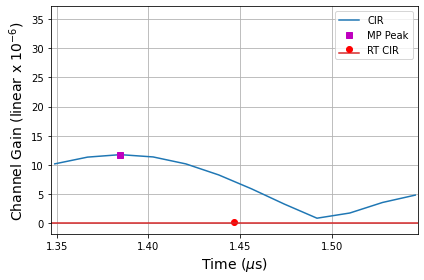

RT CIR at 0.8167815400000045 us is 50.07399999999507 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 3.04
fig_num: 13


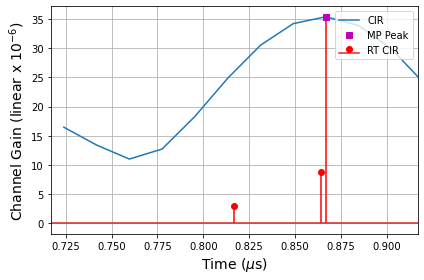

RT CIR at 0.597991540000006 us is 52.5645714285794 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.941
Scaled RT CIR amplitude: 0.04
fig_num: 14


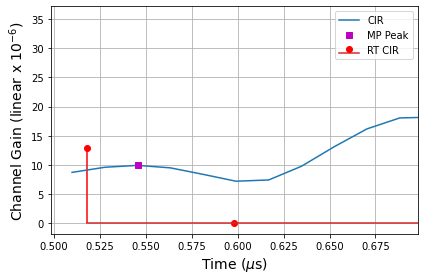

RT CIR at 0.8640875399999963 us is 2.7680000000032123 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 8.824
fig_num: 15


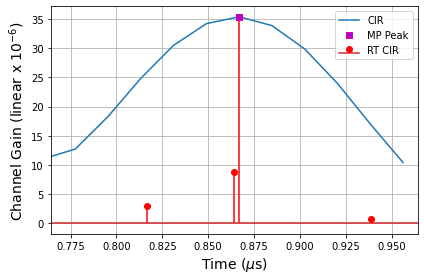

RT CIR at 0.938681540000001 us is 71.8260000000015 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 0.753
fig_num: 16


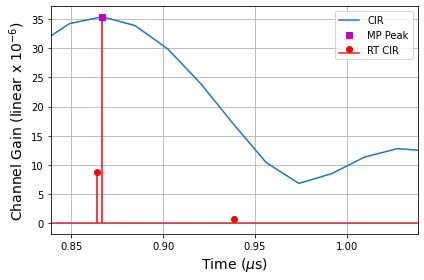

RT CIR at 1.3314215400000045 us is 53.29114285714098 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 11.777
Scaled RT CIR amplitude: 0.498
fig_num: 17


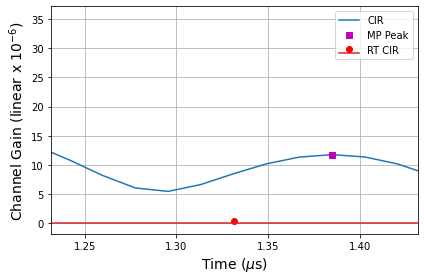

Number of total RT multipath: 10
Number of Non-matching RT multipath: 74
Number of RT multipath close in time (ns): 9
Number of Matching RT multipath (time and amplitude): 2

Pre-peak bucket matches: 1/4 --> 25.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/5 --> 0.0% match rate

 ----- PLOTNUM: 2, TX: cnode-ebc-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 

ebc-guesthouse
RX Time Delay: -24.196428571428573 us
Amplitude matching adjustment ratio [xcorr/RT]: 2.929874932923918
fig_num: 18


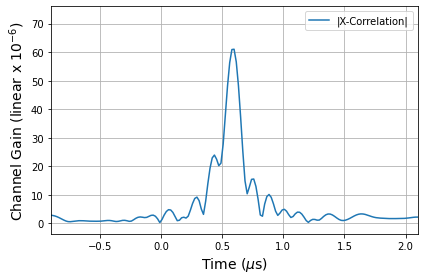

fig_num: 19


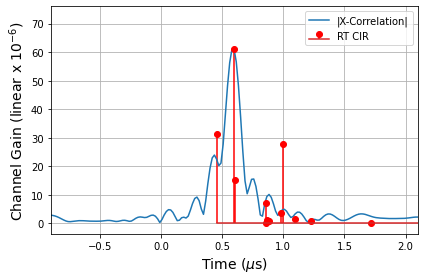

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 6
fig_num: 20


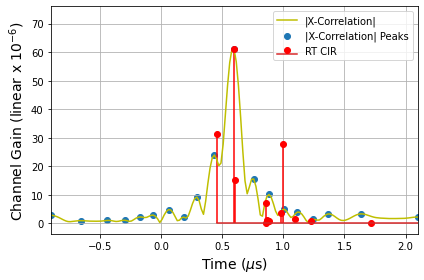

fig_num: 21


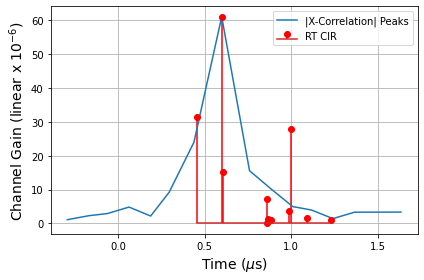

-- Total Received Power --
RT: 5784.3862309940805 W
CIR (local peaks): 4841.294700087503 W
CIR (full): 204847.33345188297 W
[-0.29482534 -0.16982534 -0.06268249  0.06231751  0.18731751  0.29446037
  0.43731751  0.5980318   0.75874609  0.88374609  1.00874609  1.11588894
  1.24088894  1.36588894  1.63374609]

-- RMS Delay Spread --
RT: 0.15732544864312178 us
CIR (local peaks): 0.12891162551776808 us
noise_std threshold: 4.439855638798562
RT CIR at 0.9980818000000014 us is 10.664285714288013 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.978
Scaled RT CIR amplitude: 27.757
fig_num: 22


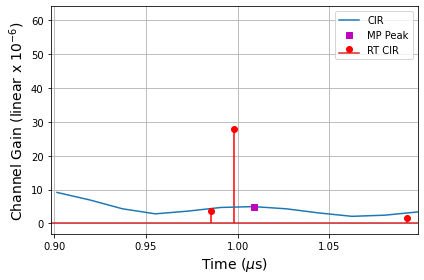

RT CIR at 0.5980318000000011 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 61.047
Scaled RT CIR amplitude: 61.047

MATCH
fig_num: 23


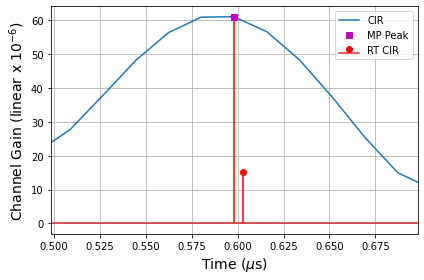

RT CIR at 1.0922417999999965 us is 83.49571428570712 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.978
Scaled RT CIR amplitude: 1.553
fig_num: 24


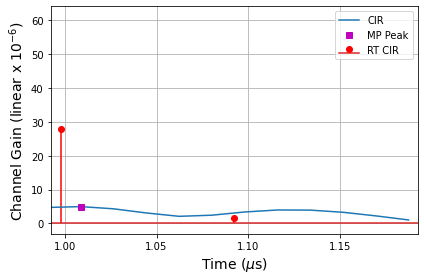

RT CIR at 0.9853988000000058 us is 23.347285714283572 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.978
Scaled RT CIR amplitude: 3.601

MATCH
fig_num: 25


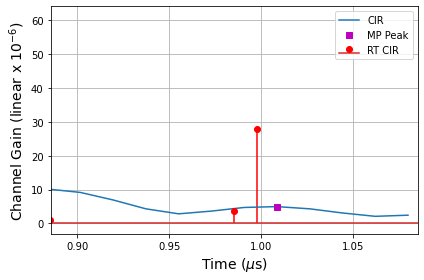

RT CIR at 0.8848658000000071 us is 1.1197142857177766 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.165
Scaled RT CIR amplitude: 0.952
fig_num: 26


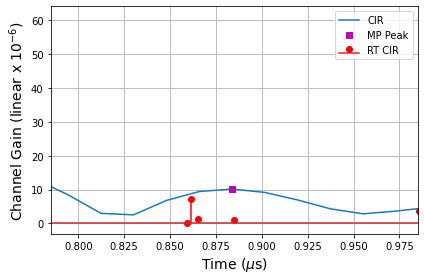

RT CIR at 0.8592518000000027 us is 24.49428571428669 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.165
Scaled RT CIR amplitude: 0.216
fig_num: 27


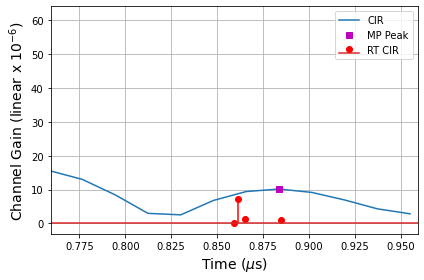

RT CIR at 0.8614718000000039 us is 22.27428571428547 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.165
Scaled RT CIR amplitude: 7.129

MATCH
fig_num: 28


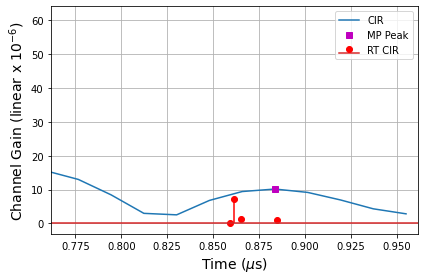

RT CIR at 0.6029618000000028 us is 4.930000000001655 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 61.047
Scaled RT CIR amplitude: 15.104
fig_num: 29


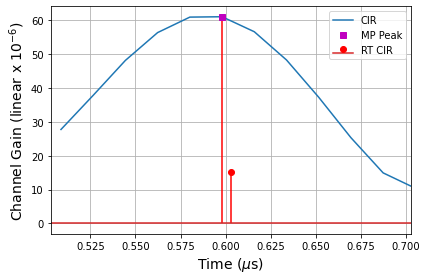

RT CIR at 0.865015800000009 us is 18.73028571428037 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.165
Scaled RT CIR amplitude: 1.282
fig_num: 30


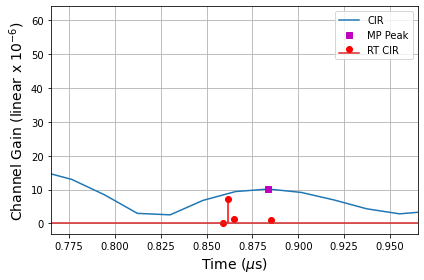

Number of total RT multipath: 11
Number of Non-matching RT multipath: 59
Number of RT multipath close in time (ns): 9
Number of Matching RT multipath (time and amplitude): 3

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 2/6 --> 33.33333333333333% match rate

 ----- PLOTNUM: 3, TX: cnode-ebc-dd-b210, RX: cnode-moran-dd-b210 ----- 

ebc-moran
RX Time Delay: -23.41071428571429 us
Amplitude matching adjustment ratio [xcorr/RT]: 9.426773875566502
fig_num: 31


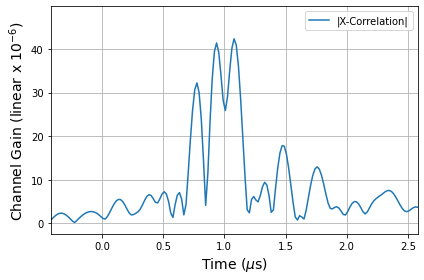

fig_num: 32


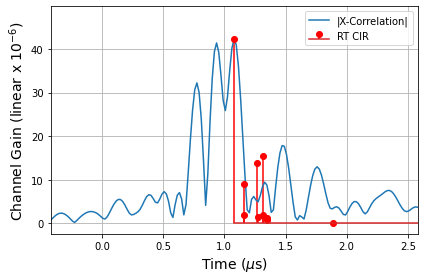

Count of measured local CIR peaks (pre-peak bucket): 6
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 7
fig_num: 33


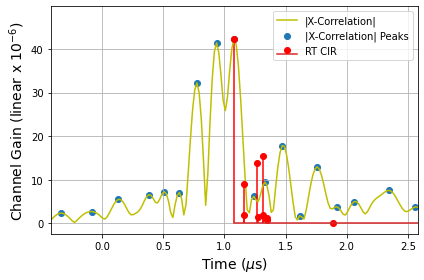

fig_num: 34


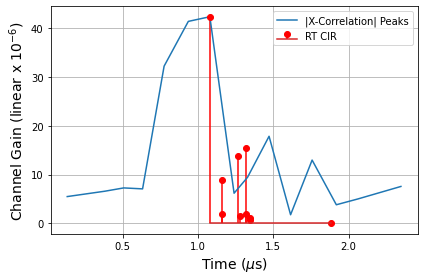

-- Total Received Power --
RT: 2318.5342887613742 W
CIR (local peaks): 5441.441971043879 W
CIR (full): 951729.9171795658 W
[0.13298223 0.38298223 0.50798223 0.63298223 0.77583937 0.93655366
 1.0794108  1.24012509 1.3294108  1.47226794 1.61512509 1.75798223
 1.91869651 2.06155366 2.34726794]

-- RMS Delay Spread --
RT: 0.08562076117939613 us
CIR (local peaks): 0.28831642394765195 us
noise_std threshold: 8.91165364156828
RT CIR at 1.346990800000011 us is 17.580000000005924 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.459
Scaled RT CIR amplitude: 0.698
fig_num: 35


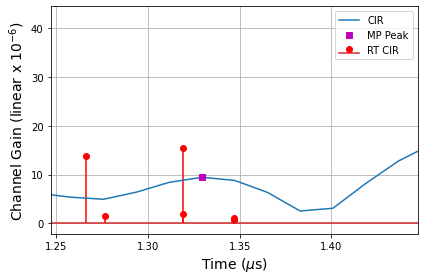

RT CIR at 1.3468407999999918 us is 17.429999999986734 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.459
Scaled RT CIR amplitude: 1.221
fig_num: 36


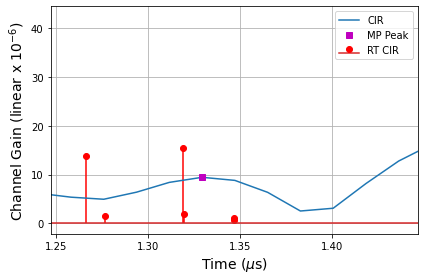

Number of total RT multipath: 14
Number of Non-matching RT multipath: 66
Number of RT multipath close in time (ns): 2
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/6 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/7 --> 0.0% match rate

 ----- PLOTNUM: 4, TX: cnode-mario-dd-b210, RX: cnode-ebc-dd-b210 ----- 

mario-ebc
RX Time Delay: 82.39285714285714 us
Amplitude matching adjustment ratio [xcorr/RT]: 6.44383027501725
fig_num: 37


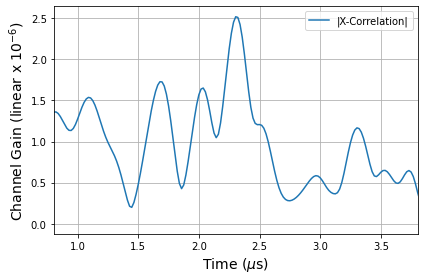

fig_num: 38


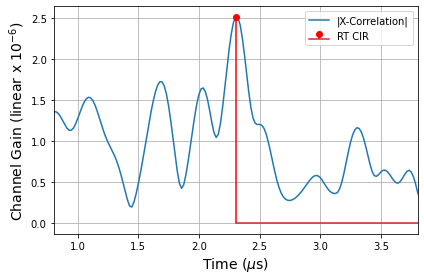

Count of measured local CIR peaks (pre-peak bucket): 2
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 3
fig_num: 39


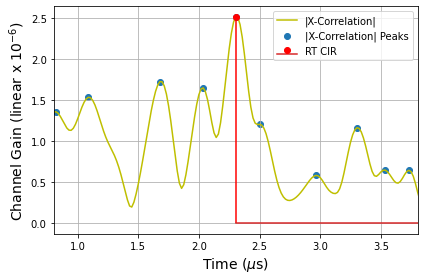

fig_num: 40


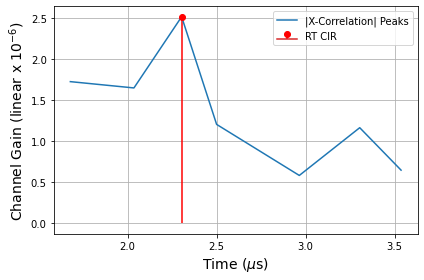

-- Total Received Power --
RT: 6.340660409262239 W
CIR (local peaks): 15.630830358375418 W
CIR (full): 32288.98969955283 W
[1.678586   2.03572886 2.303586   2.50001457 2.96430029 3.303586
 3.53572886]

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.477580032657244 us
noise_std threshold: 1.6737733577533707
Number of total RT multipath: 6
Number of Non-matching RT multipath: 10
Number of RT multipath close in time (ns): 0
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/2 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/3 --> 0.0% match rate

 ----- PLOTNUM: 5, TX: cnode-mario-dd-b210, RX: cnode-ustar-dd-b210 ----- 

mario-ustar
RX Time Delay: 275.44642857142856 us
Amplitude matching adjustment ratio [xcorr/RT]: 0.13073768079552098
fig_num: 41


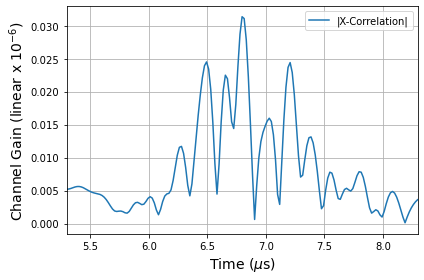

fig_num: 42


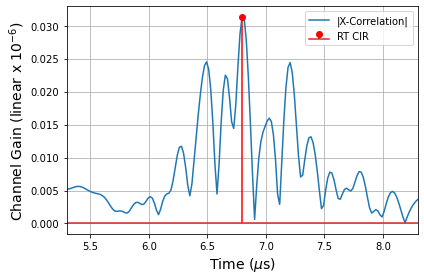

Count of measured local CIR peaks (pre-peak bucket): 5
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 6
fig_num: 43


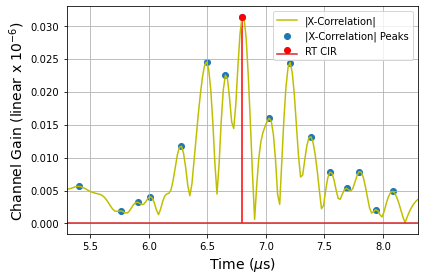

fig_num: 44


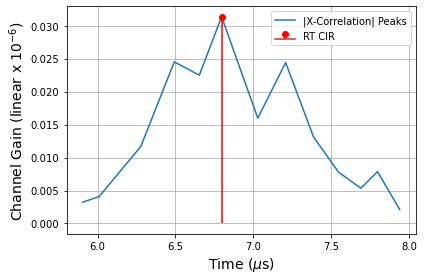

-- Total Received Power --
RT: 0.0009838178008569002 W
CIR (local peaks): 0.0034344856584213167 W
CIR (full): 0.9420889967543289 W
[5.90294416 6.01008701 6.27794416 6.49222987 6.65294416 6.7958013
 7.02794416 7.20651559 7.38508701 7.5458013  7.68865844 7.7958013
 7.93865844]

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.3448794978560367 us
noise_std threshold: 0.009361516592533994
Number of total RT multipath: 12
Number of Non-matching RT multipath: 10
Number of RT multipath close in time (ns): 0
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/5 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/6 --> 0.0% match rate

 ----- PLOTNUM: 6, TX: cnode-mario-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 

mario-guesthouse
RX Time Delay: -95.76785714285714 us
Amplitude matching adjustment ratio [xcorr/RT]: 0.0
fig_num: 45


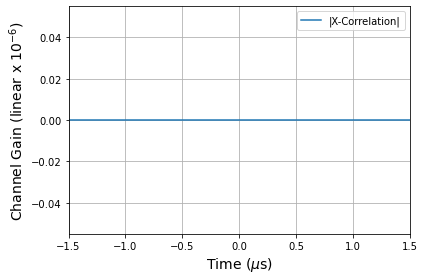

fig_num: 46


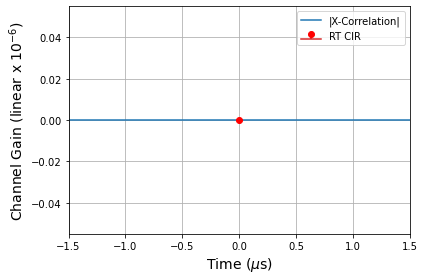

Count of measured local CIR peaks (pre-peak bucket): 0
Count of measured local CIR peaks (surrounding-peak bucket): 0
Count of measured local CIR peaks (post-peak bucket): 0
fig_num: 47


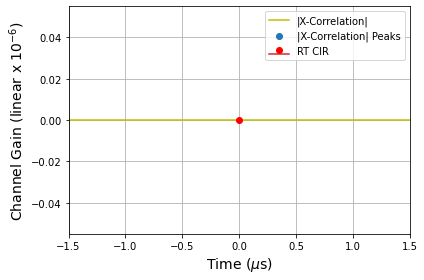


 ----- PLOTNUM: 7, TX: cnode-mario-dd-b210, RX: cnode-moran-dd-b210 ----- 

mario-moran
RX Time Delay: 274.75 us
Amplitude matching adjustment ratio [xcorr/RT]: 22.903633367419204
fig_num: 48


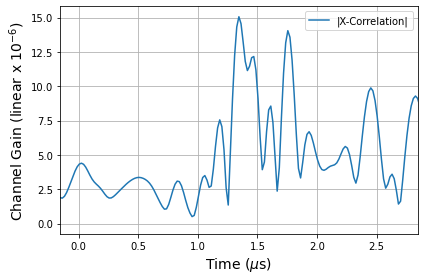

fig_num: 49


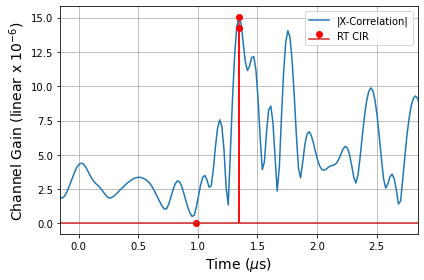

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 5
fig_num: 50


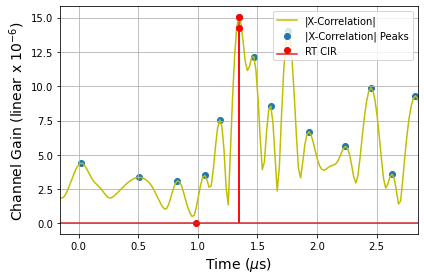

fig_num: 51


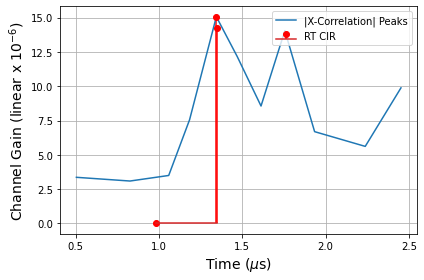

-- Total Received Power --
RT: 429.98212125845237 W
CIR (local peaks): 909.0869623463071 W
CIR (full): 518457.43732938525 W
[0.50483479 0.82626336 1.05840621 1.18340621 1.3441205  1.4691205
 1.61197764 1.75483479 1.93340621 2.23697764 2.45126336]

-- RMS Delay Spread --
RT: 0.002387319181721678 us
CIR (local peaks): 0.39637966068850855 us
noise_std threshold: 6.6199659276483445
Number of total RT multipath: 10
Number of Non-matching RT multipath: 6
Number of RT multipath close in time (ns): 0
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/5 --> 0.0% match rate

 ----- PLOTNUM: 8, TX: cnode-ustar-dd-b210, RX: cnode-ebc-dd-b210 ----- 

ustar-ebc
RX Time Delay: -104.71428571428571 us
Amplitude matching adjustment ratio [xcorr/RT]: 11.368775620420381
fig_num: 52


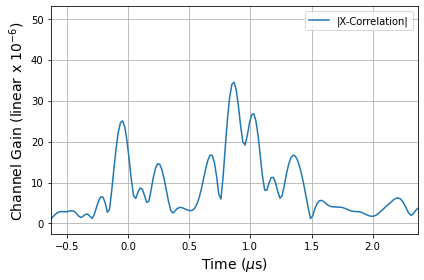

fig_num: 53


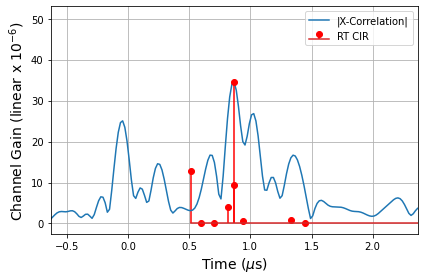

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 4
fig_num: 54


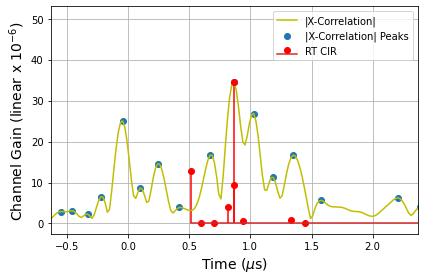

fig_num: 55


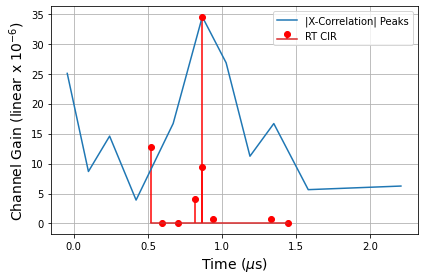

-- Total Received Power --
RT: 1462.4442147892028 W
CIR (local peaks): 3596.7411225220653 W
CIR (full): 297580.46047750185 W
[-0.04385875  0.0989984   0.24185554  0.42042697  0.67042697  0.86685554
  1.02756983  1.18828411  1.3489984   1.58114125  2.20614125]

-- RMS Delay Spread --
RT: 0.11079423082938493 us
CIR (local peaks): 0.4675500837144333 us
noise_std threshold: 5.335543756123398
RT CIR at 0.8668555400000031 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 34.521

MATCH
fig_num: 56


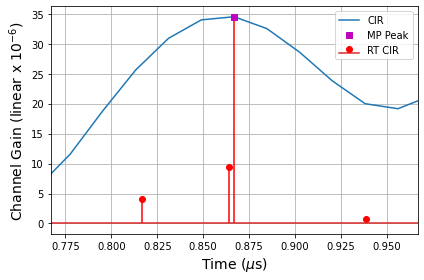

RT CIR at 0.5979915400000095 us is 72.43542857140994 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 16.69
Scaled RT CIR amplitude: 0.084
fig_num: 57


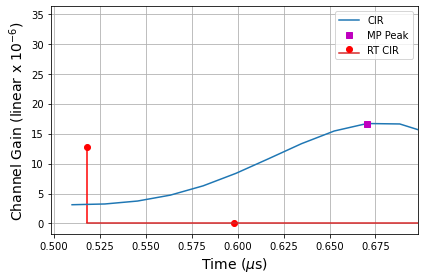

RT CIR at 0.7010215400000135 us is 30.59457142859401 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 16.69
Scaled RT CIR amplitude: 0.069
fig_num: 58


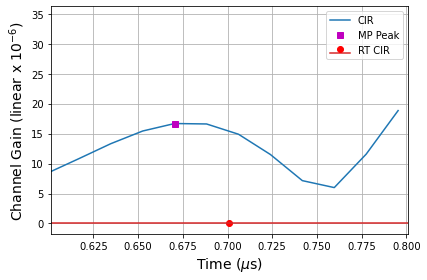

RT CIR at 1.331421540000008 us is 17.576857142856284 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 16.682
Scaled RT CIR amplitude: 0.818
fig_num: 59


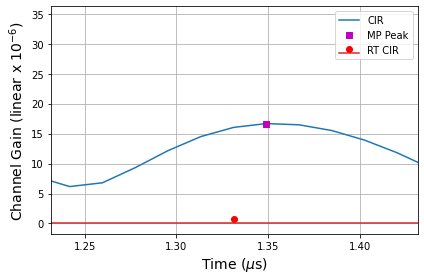

RT CIR at 0.9386815400000046 us is 71.8260000000015 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 0.667
fig_num: 60


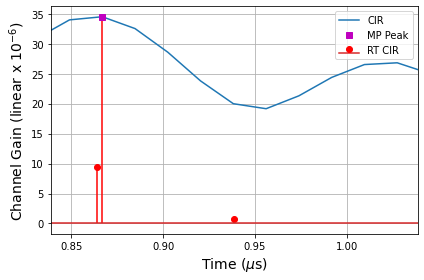

RT CIR at 0.8640875399999999 us is 2.7680000000032123 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 9.387
fig_num: 61


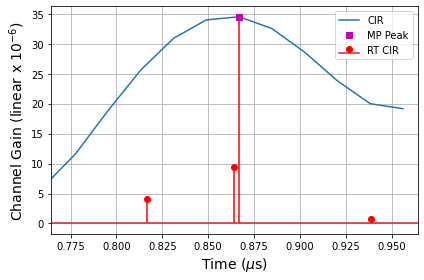

RT CIR at 0.816781540000008 us is 50.07399999999507 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 4.056
fig_num: 62


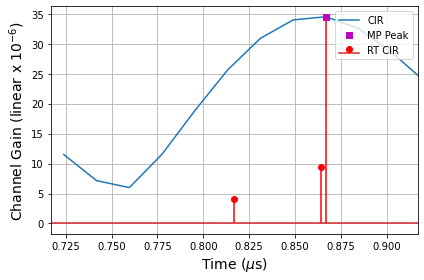

Number of total RT multipath: 9
Number of Non-matching RT multipath: 76
Number of RT multipath close in time (ns): 7
Number of Matching RT multipath (time and amplitude): 1

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/4 --> 0.0% match rate

 ----- PLOTNUM: 9, TX: cnode-ustar-dd-b210, RX: cnode-mario-dd-b210 ----- 

ustar-mario
RX Time Delay: 284.75 us
Amplitude matching adjustment ratio [xcorr/RT]: 0.024006929807113525
fig_num: 63


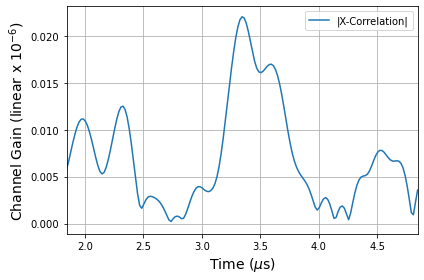

fig_num: 64


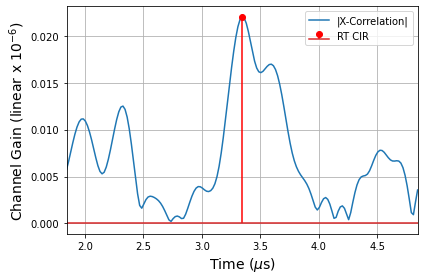

Count of measured local CIR peaks (pre-peak bucket): 3
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 3
fig_num: 65


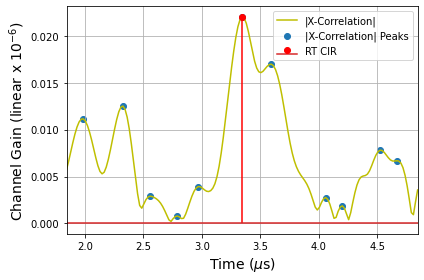

fig_num: 66


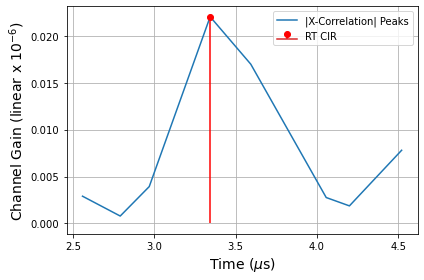

-- Total Received Power --
RT: 0.00048571126194416406 W
CIR (local peaks): 0.0008706411898860808 W
CIR (full): 2.8447064148455716 W
[2.55741291 2.78955577 2.9681272  3.3431272  3.5931272  4.05741291
 4.20027006 4.52169863]

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.3291498396850599 us
noise_std threshold: 0.014870567054488923
RT CIR at 3.3431272000000263 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 0.022
Scaled RT CIR amplitude: 0.022

MATCH
fig_num: 67


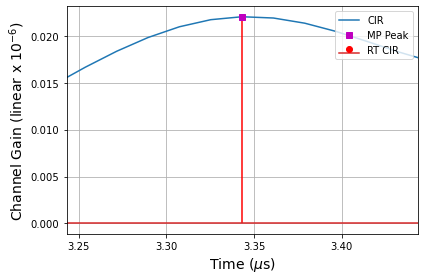

Number of total RT multipath: 7
Number of Non-matching RT multipath: 9
Number of RT multipath close in time (ns): 1
Number of Matching RT multipath (time and amplitude): 1

Pre-peak bucket matches: 0/3 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/3 --> 0.0% match rate

 ----- PLOTNUM: 10, TX: cnode-ustar-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 

ustar-guesthouse
RX Time Delay: -105.125 us
Amplitude matching adjustment ratio [xcorr/RT]: 17.392271446051975
fig_num: 68


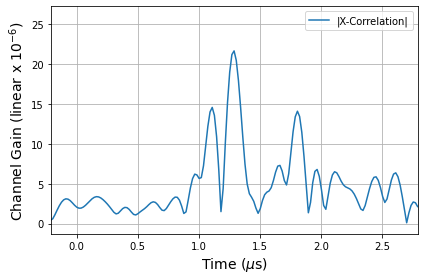

fig_num: 69


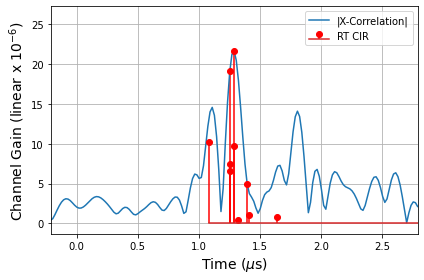

Count of measured local CIR peaks (pre-peak bucket): 5
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 4
fig_num: 70


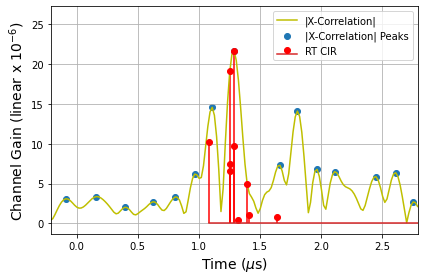

fig_num: 71


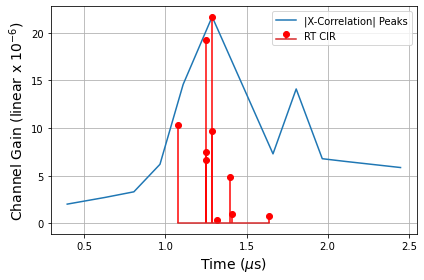

-- Total Received Power --
RT: 1165.3499492005253 W
CIR (local peaks): 1118.4176495685144 W
CIR (full): 282438.27530058345 W
[0.39503076 0.62717361 0.80574504 0.96645933 1.10931647 1.2878879
 1.6628879  1.80574504 1.96645933 2.10931647 2.44860219]

-- RMS Delay Spread --
RT: 0.06212053297984645 us
CIR (local peaks): 0.36928110929158137 us
noise_std threshold: 4.782442854612353
RT CIR at 1.0788979000000012 us is 30.418571428569408 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 14.58
Scaled RT CIR amplitude: 10.293

MATCH
fig_num: 72


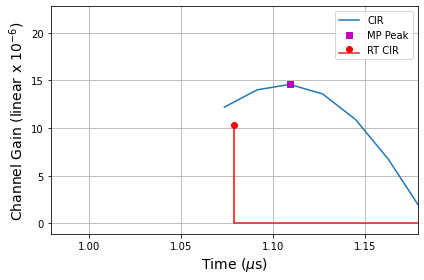

RT CIR at 1.2524178999999975 us is 35.470000000003665 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 19.211

MATCH
fig_num: 73


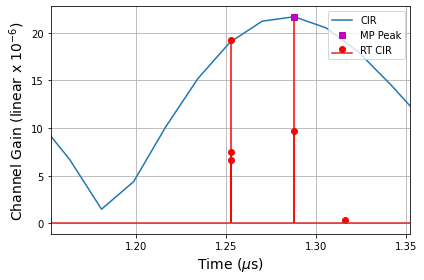

RT CIR at 1.2878879000000012 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 21.676

MATCH
fig_num: 74


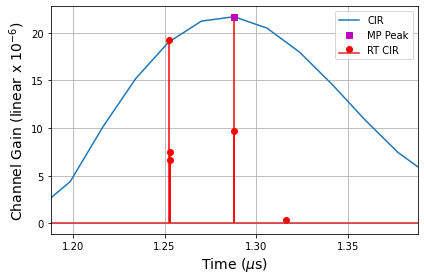

RT CIR at 69.72859789999997 us is 59.290000000032705 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.027
Scaled RT CIR amplitude: 0.0
fig_num: 75


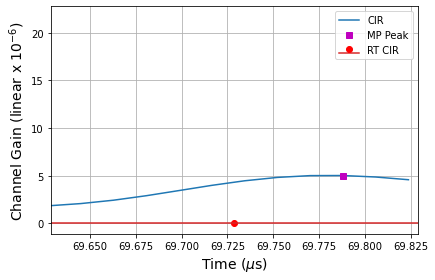

RT CIR at 1.639417899999998 us is 23.47000000000321 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 7.299
Scaled RT CIR amplitude: 0.82
fig_num: 76


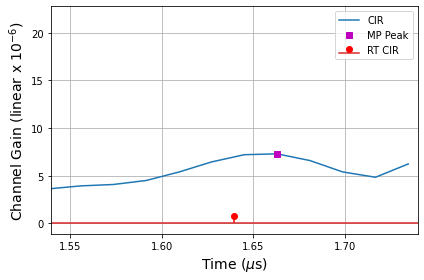

RT CIR at 1.2529278999999889 us is 34.960000000012315 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 7.472
fig_num: 77


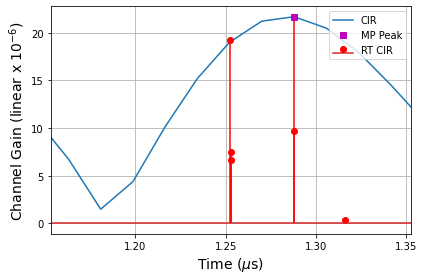

RT CIR at 1.2527578999999918 us is 35.13000000000943 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 6.65
fig_num: 78


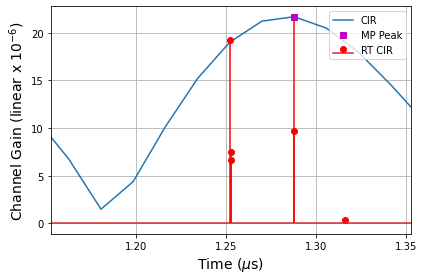

RT CIR at 1.2878879000000012 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 9.718
fig_num: 79


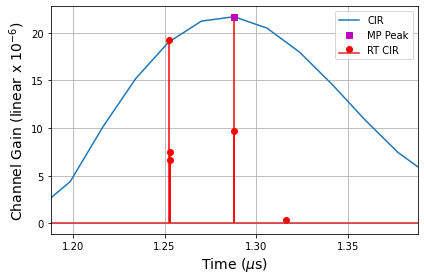

RT CIR at 1.3161178999999805 us is 28.229999999979327 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 0.412
fig_num: 80


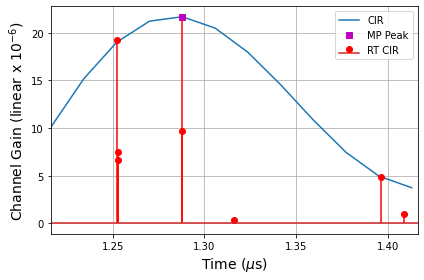

Number of total RT multipath: 10
Number of Non-matching RT multipath: 61
Number of RT multipath close in time (ns): 9
Number of Matching RT multipath (time and amplitude): 3

Pre-peak bucket matches: 1/5 --> 20.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 2/1 --> 200.0% match rate
Post-peak bucket matches: 0/4 --> 0.0% match rate

 ----- PLOTNUM: 11, TX: cnode-ustar-dd-b210, RX: cnode-moran-dd-b210 ----- 

ustar-moran
RX Time Delay: -105.75 us
Amplitude matching adjustment ratio [xcorr/RT]: 5.666608254319864
fig_num: 81


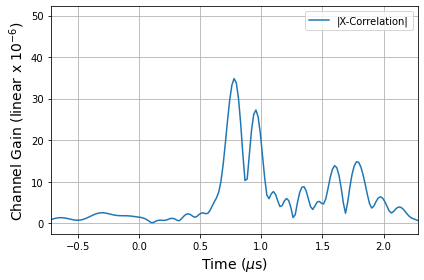

fig_num: 82


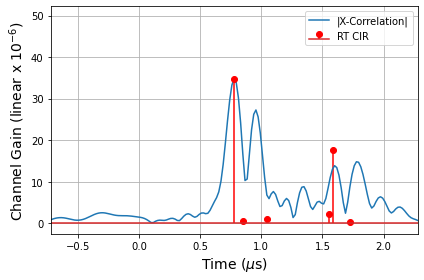

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 6
fig_num: 83


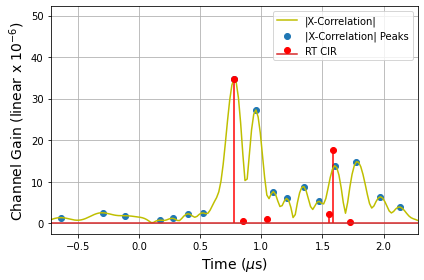

fig_num: 84


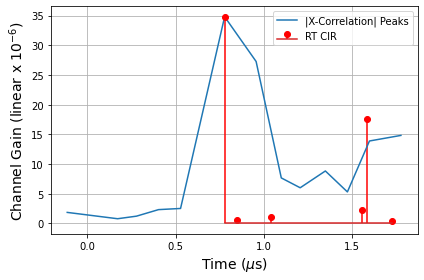

-- Total Received Power --
RT: 1528.7794534641623 W
CIR (local peaks): 2589.286722334259 W
CIR (full): 105524.1763716306 W
[-0.11483104  0.17088324  0.2780261   0.4030261   0.5280261   0.7780261
  0.95659753  1.09945467  1.20659753  1.34945467  1.47445467  1.59945467
  1.7780261 ]

-- RMS Delay Spread --
RT: 0.3273976792860295 us
CIR (local peaks): 0.3348761333358574 us
noise_std threshold: 3.4162349650531385
RT CIR at 0.7780261000000053 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.825
Scaled RT CIR amplitude: 34.825

MATCH
fig_num: 85


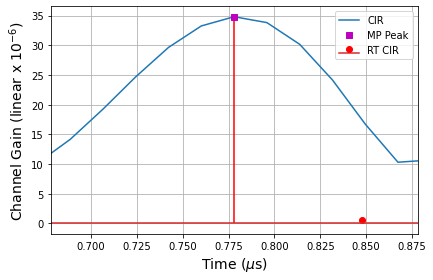

RT CIR at 1.5883690999999942 us is 11.085571428580465 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 13.893
Scaled RT CIR amplitude: 17.585

MATCH
fig_num: 86


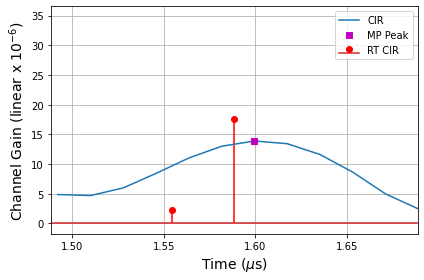

RT CIR at 1.554696100000001 us is 80.24142857142635 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.316
Scaled RT CIR amplitude: 2.275
fig_num: 87


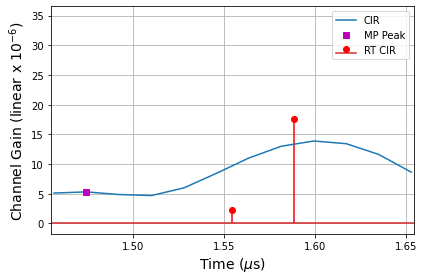

RT CIR at 0.8478021000000098 us is 69.7760000000045 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.825
Scaled RT CIR amplitude: 0.573
fig_num: 88


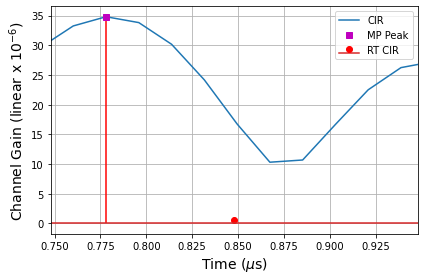

RT CIR at 1.7276660999999933 us is 50.36000000001195 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 14.834
Scaled RT CIR amplitude: 0.454
fig_num: 89


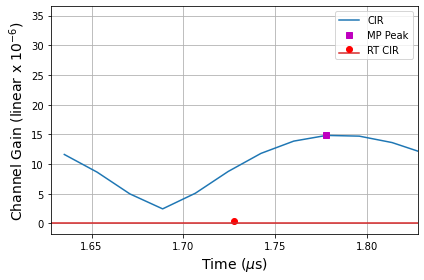

RT CIR at 1.043110100000007 us is 86.51257142857105 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 27.286
Scaled RT CIR amplitude: 1.029
fig_num: 90


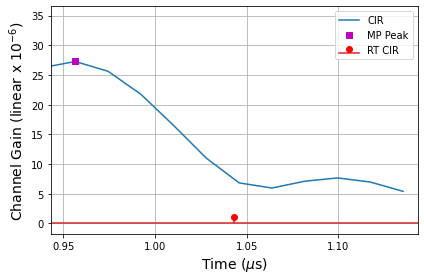

RT CIR at 3.7130511000000013 us is 11.4035714285734 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 3.992
Scaled RT CIR amplitude: 0.003
fig_num: 91


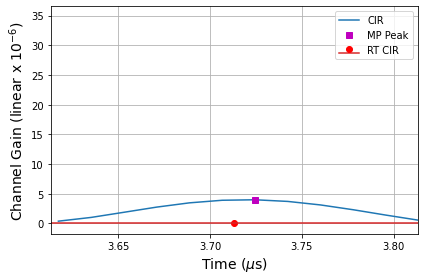

Number of total RT multipath: 11
Number of Non-matching RT multipath: 58
Number of RT multipath close in time (ns): 7
Number of Matching RT multipath (time and amplitude): 2

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 1/6 --> 16.666666666666664% match rate

 ----- PLOTNUM: 12, TX: cnode-guesthouse-dd-b210, RX: cnode-ebc-dd-b210 ----- 

guesthouse-ebc
RX Time Delay: -281.5178571428571 us
Amplitude matching adjustment ratio [xcorr/RT]: 5.317551802440359
fig_num: 92


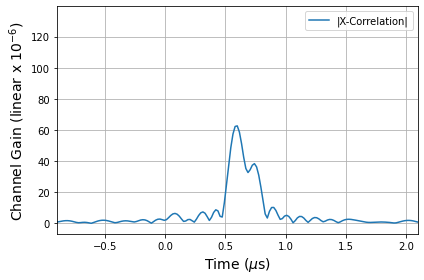

fig_num: 93


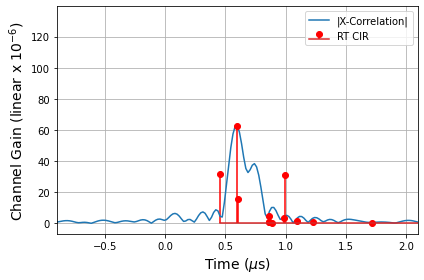

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 7
fig_num: 94


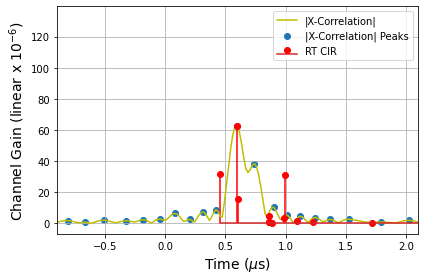

fig_num: 95


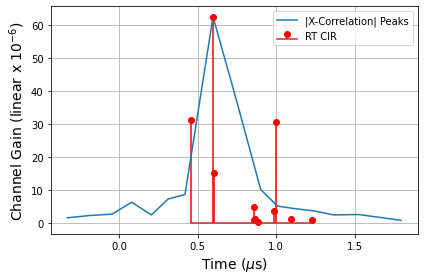

-- Total Received Power --
RT: 6149.474649799339 W
CIR (local peaks): 5780.7847492277415 W
CIR (full): 368556.6655260177 W
[-0.33053963 -0.18768249 -0.04482534  0.08017466  0.20517466  0.31231751
  0.41946037  0.5980318   0.74088894  0.90160323  1.00874609  1.11588894
  1.24088894  1.36588894  1.52660323  1.79446037]

-- RMS Delay Spread --
RT: 0.164449936986047 us
CIR (local peaks): 0.12307257661314318 us
noise_std threshold: 5.118402945675718
RT CIR at 0.5980318000000011 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 62.653
Scaled RT CIR amplitude: 62.653

MATCH
fig_num: 96


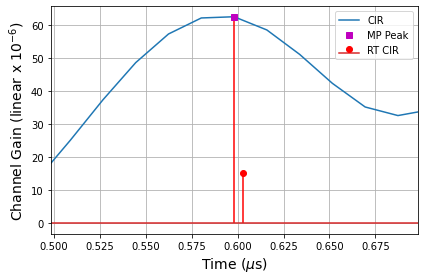

RT CIR at 0.9980818000000227 us is 10.664285714256039 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.25
Scaled RT CIR amplitude: 30.875
fig_num: 97


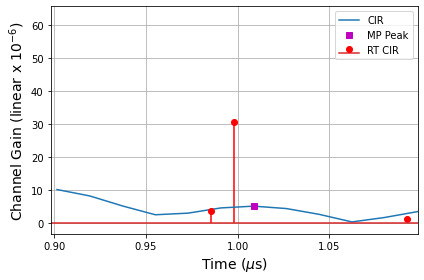

RT CIR at 0.6029618000000028 us is 4.930000000001655 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 62.653
Scaled RT CIR amplitude: 15.417
fig_num: 98


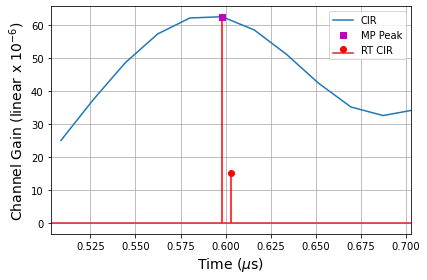

RT CIR at 0.8592517999999814 us is 42.35142857140772 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.281
Scaled RT CIR amplitude: 1.083
fig_num: 99


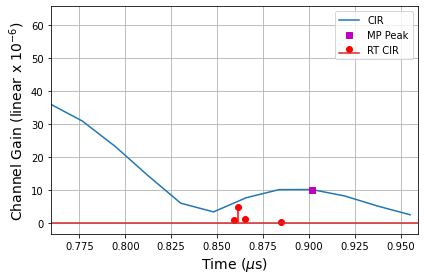

RT CIR at 0.8614718000000039 us is 40.131428571385186 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.281
Scaled RT CIR amplitude: 4.902
fig_num: 100


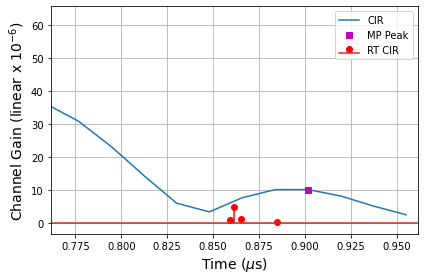

RT CIR at 0.8650157999999806 us is 36.58742857140851 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.281
Scaled RT CIR amplitude: 1.227
fig_num: 101


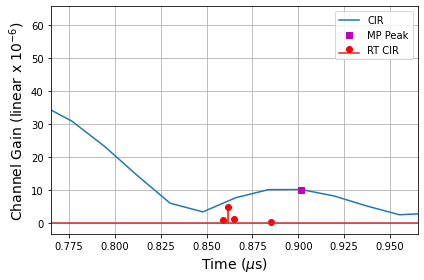

RT CIR at 0.8848658 us is 16.737428571389046 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.281
Scaled RT CIR amplitude: 0.431
fig_num: 102


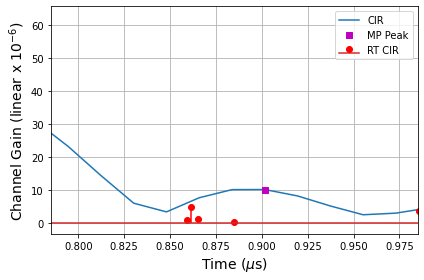

RT CIR at 0.9853987999999845 us is 83.7955714285954 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.281
Scaled RT CIR amplitude: 3.632
fig_num: 103


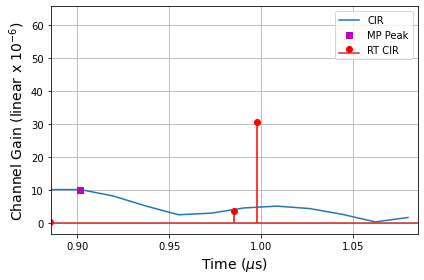

RT CIR at 1.0922418000000107 us is 83.49571428573199 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.25
Scaled RT CIR amplitude: 1.461
fig_num: 104


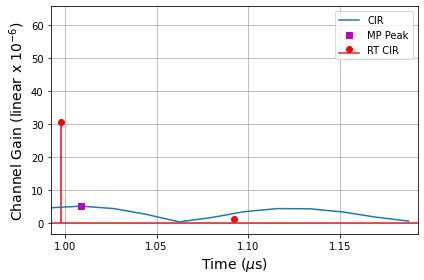

Number of total RT multipath: 12
Number of Non-matching RT multipath: 58
Number of RT multipath close in time (ns): 9
Number of Matching RT multipath (time and amplitude): 1

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/7 --> 0.0% match rate

 ----- PLOTNUM: 13, TX: cnode-guesthouse-dd-b210, RX: cnode-mario-dd-b210 ----- 

guesthouse-mario
RX Time Delay: 227.05357142857144 us
Amplitude matching adjustment ratio [xcorr/RT]: 0.18669775731122826
fig_num: 105


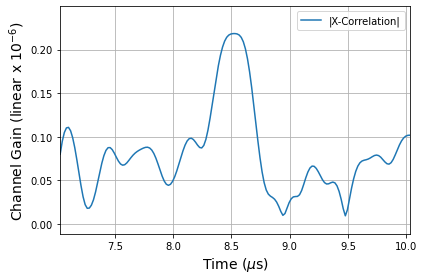

fig_num: 106


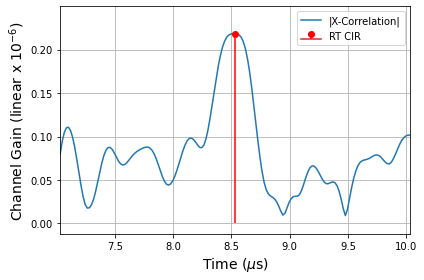

Count of measured local CIR peaks (pre-peak bucket): 2
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 2
fig_num: 107


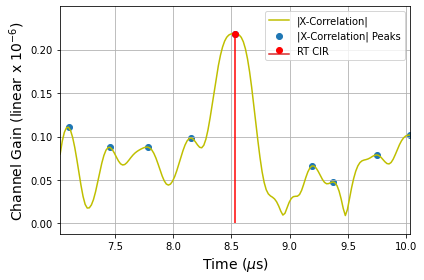


 ----- PLOTNUM: 14, TX: cnode-guesthouse-dd-b210, RX: cnode-ustar-dd-b210 ----- 

guesthouse-ustar
RX Time Delay: -280.75 us
Amplitude matching adjustment ratio [xcorr/RT]: 41.09535071713303
fig_num: 108


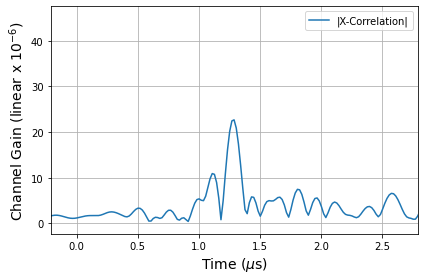

fig_num: 109


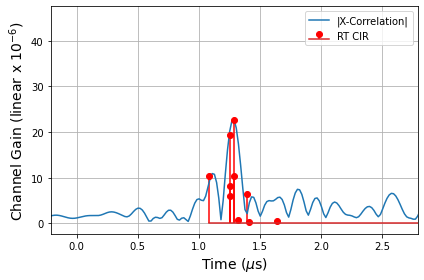

Count of measured local CIR peaks (pre-peak bucket): 6
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 6
fig_num: 110


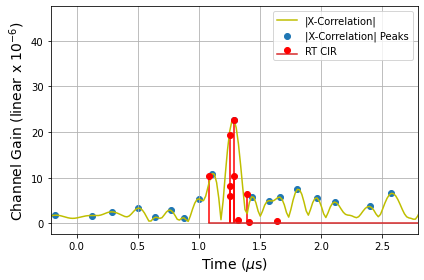

fig_num: 111


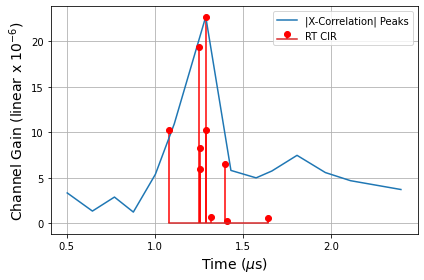

-- Total Received Power --
RT: 1250.699692808986 W
CIR (local peaks): 901.7358075402458 W
CIR (full): 881247.2611490008 W
[0.50217361 0.64503076 0.77003076 0.87717361 1.00217361 1.10931647
 1.2878879  1.43074504 1.57360219 1.6628879  1.80574504 1.96645933
 2.10931647 2.39503076]

-- RMS Delay Spread --
RT: 0.06207503367632437 us
CIR (local peaks): 0.2989888501897111 us
noise_std threshold: 11.056493097850867
RT CIR at 1.252417899999955 us is 35.47000000003209 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 19.412

MATCH
fig_num: 112


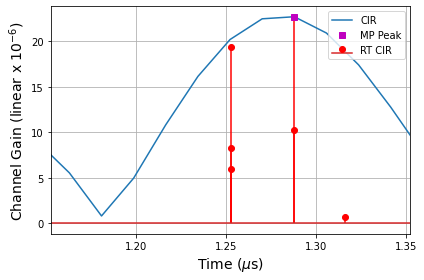

RT CIR at 1.287887899999987 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 22.692

MATCH
fig_num: 113


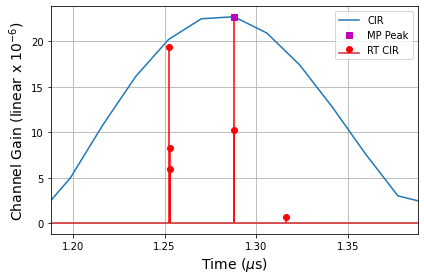

RT CIR at 1.287887899999987 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 10.307
fig_num: 114


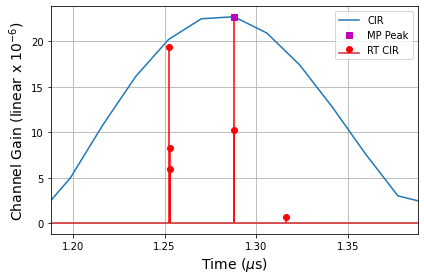

RT CIR at 1.3161178999999947 us is 28.23000000000775 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 0.717
fig_num: 115


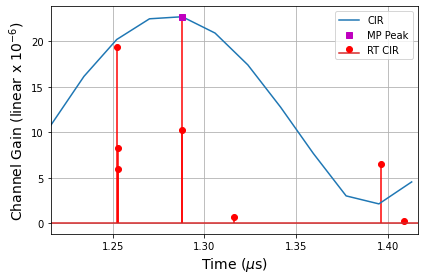

RT CIR at 1.2529278999999747 us is 34.960000000012315 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 8.257
fig_num: 116


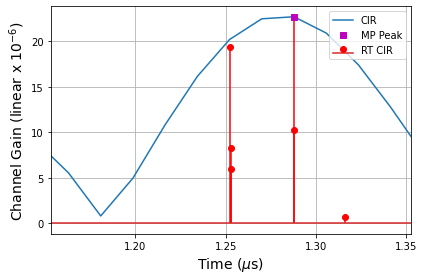

RT CIR at 1.252757900000006 us is 35.12999999998101 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 5.941
fig_num: 117


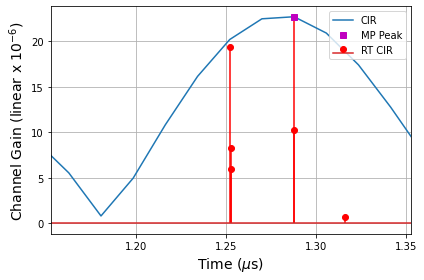

Number of total RT multipath: 13
Number of Non-matching RT multipath: 64
Number of RT multipath close in time (ns): 6
Number of Matching RT multipath (time and amplitude): 2

Pre-peak bucket matches: 0/6 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 2/1 --> 200.0% match rate
Post-peak bucket matches: 0/6 --> 0.0% match rate

 ----- PLOTNUM: 15, TX: cnode-guesthouse-dd-b210, RX: cnode-moran-dd-b210 ----- 

guesthouse-moran
RX Time Delay: -280.5535714285714 us
Amplitude matching adjustment ratio [xcorr/RT]: 31.83635098686273
fig_num: 118


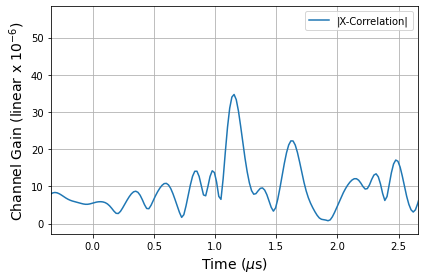

fig_num: 119


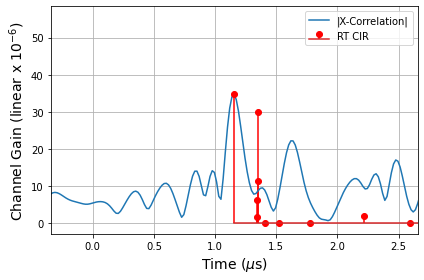

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 3
fig_num: 120


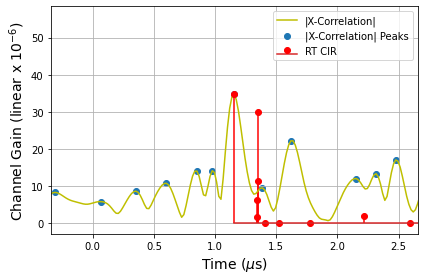

fig_num: 121


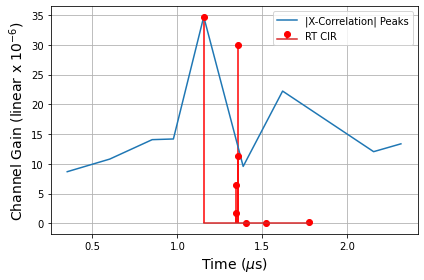

-- Total Received Power --
RT: 2279.8978128609547 W
CIR (local peaks): 2706.050399264855 W
CIR (full): 4383114.218051608 W
[0.35145697 0.60145697 0.85145697 0.97645697 1.1550284  1.38717126
 1.61931411 2.1550284  2.31574269]

-- RMS Delay Spread --
RT: 0.09911903203282098 us
CIR (local peaks): 0.4520043956144553 us
noise_std threshold: 18.427366585695488
Number of total RT multipath: 8
Number of Non-matching RT multipath: 49
Number of RT multipath close in time (ns): 0
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/3 --> 0.0% match rate

 ----- PLOTNUM: 16, TX: cnode-moran-dd-b210, RX: cnode-ebc-dd-b210 ----- 

moran-ebc
RX Time Delay: 186.98214285714286 us
Amplitude matching adjustment ratio [xcorr/RT]: 11.385878706116555
fig_num: 122


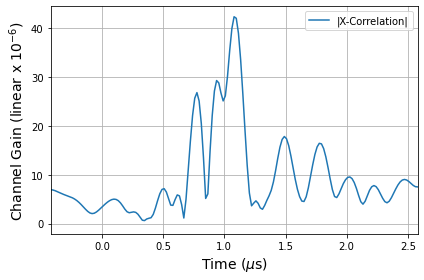

fig_num: 123


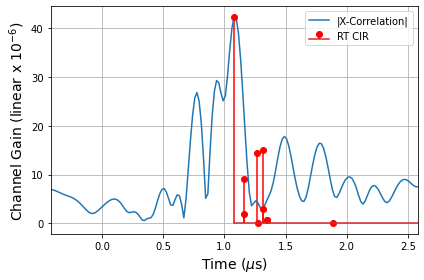

Count of measured local CIR peaks (pre-peak bucket): 6
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 4
fig_num: 124


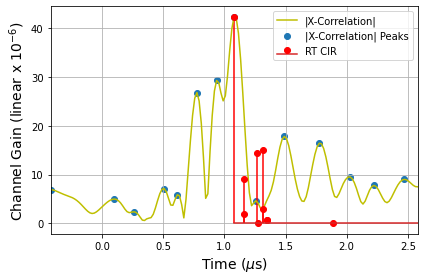

fig_num: 125


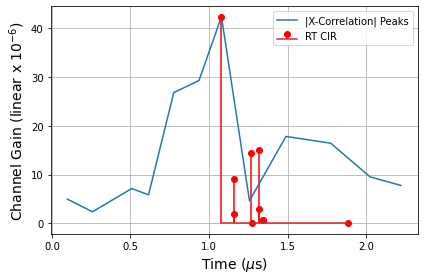

-- Total Received Power --
RT: 2324.227112648726 W
CIR (local peaks): 4249.629286714766 W
CIR (full): 1499846.9389177635 W
[0.09726794 0.25798223 0.50798223 0.61512509 0.77583937 0.93655366
 1.0794108  1.25798223 1.49012509 1.77583937 2.02583937 2.22226794]

-- RMS Delay Spread --
RT: 0.08524128034397731 us
CIR (local peaks): 0.3365202456558231 us
noise_std threshold: 10.95115748648583
RT CIR at 137.74520080000005 us is 84.20999999992773 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 13.747
Scaled RT CIR amplitude: 0.005
fig_num: 126


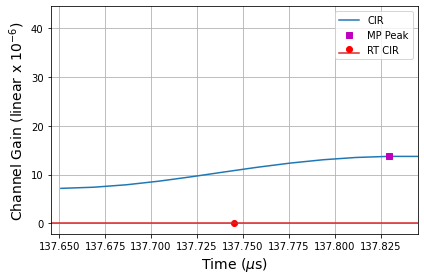

RT CIR at 94.55123080000001 us is 63.894285714297894 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.892
Scaled RT CIR amplitude: 0.103
fig_num: 127


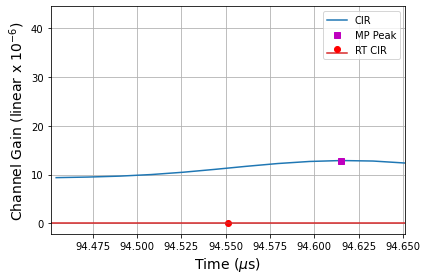

RT CIR at 24.093730800000003 us is 67.89142857141428 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.998
Scaled RT CIR amplitude: 0.007
fig_num: 128


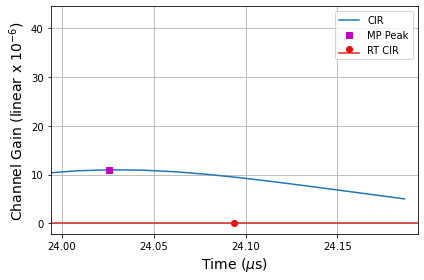

Number of total RT multipath: 11
Number of Non-matching RT multipath: 66
Number of RT multipath close in time (ns): 3
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/6 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/4 --> 0.0% match rate

 ----- PLOTNUM: 17, TX: cnode-moran-dd-b210, RX: cnode-mario-dd-b210 ----- 

moran-mario
RX Time Delay: -25.91071428571429 us
Amplitude matching adjustment ratio [xcorr/RT]: 7.155322724233532
fig_num: 129


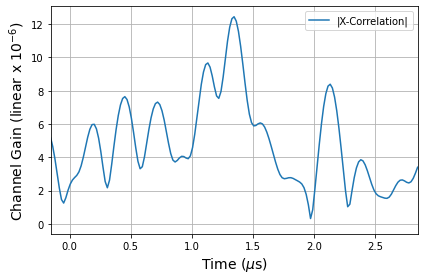

fig_num: 130


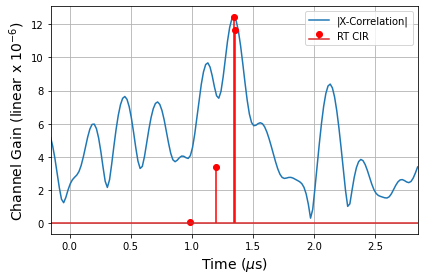

Count of measured local CIR peaks (pre-peak bucket): 4
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 3
fig_num: 131


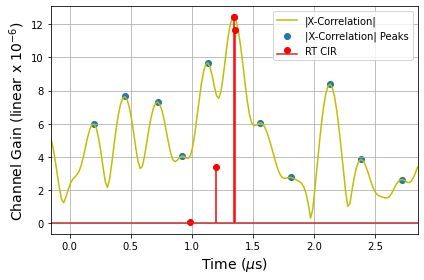

fig_num: 132


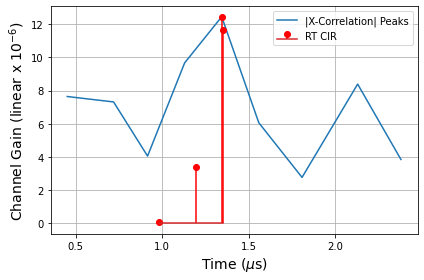

-- Total Received Power --
RT: 302.46578340540225 W
CIR (local peaks): 506.76356016370596 W
CIR (full): 1015840.6155077595 W
[0.45126346 0.7191206  0.91554917 1.12983489 1.3441206  1.55840631
 1.80840631 2.12983489 2.37983489]

-- RMS Delay Spread --
RT: 0.028887093120087845 us
CIR (local peaks): 0.5176051418467968 us
noise_std threshold: 8.968665650159958
RT CIR at 1.3441206 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.449
Scaled RT CIR amplitude: 12.449

MATCH
fig_num: 133


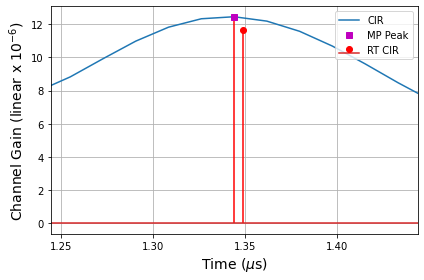

RT CIR at 1.3487705999999982 us is 4.649999999998045 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.449
Scaled RT CIR amplitude: 11.652

MATCH
fig_num: 134


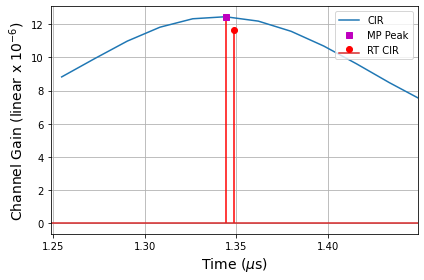

Number of total RT multipath: 8
Number of Non-matching RT multipath: 6
Number of RT multipath close in time (ns): 2
Number of Matching RT multipath (time and amplitude): 2

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 2/1 --> 200.0% match rate
Post-peak bucket matches: 0/3 --> 0.0% match rate

 ----- PLOTNUM: 18, TX: cnode-moran-dd-b210, RX: cnode-ustar-dd-b210 ----- 

moran-ustar
RX Time Delay: 186.41071428571428 us
Amplitude matching adjustment ratio [xcorr/RT]: 5.021583721839034
fig_num: 135


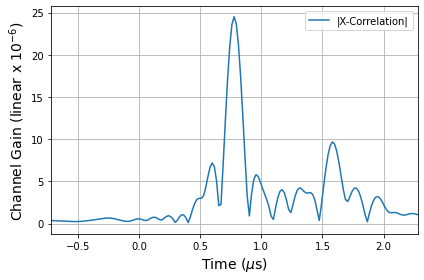

fig_num: 136


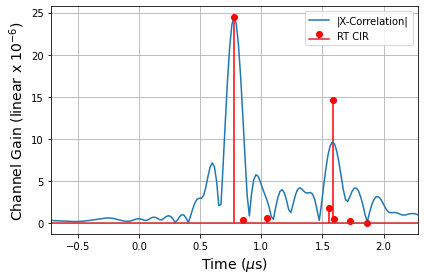

Count of measured local CIR peaks (pre-peak bucket): 5
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 6
fig_num: 137


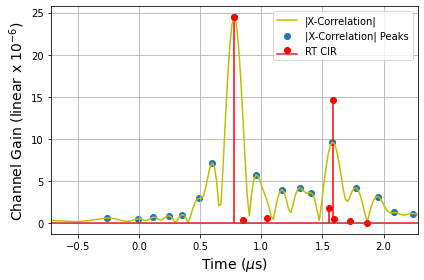

fig_num: 138


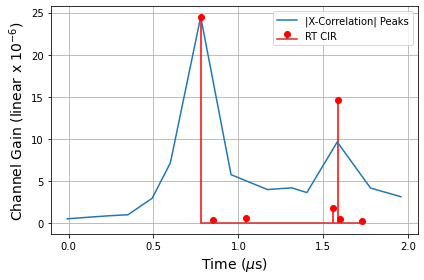

-- Total Received Power --
RT: 820.2747532042944 W
CIR (local peaks): 865.6900846874017 W
CIR (full): 34745.74546692454 W
[-0.00768824  0.11731176  0.24231176  0.34945462  0.49231176  0.59945462
  0.77802605  0.95659748  1.17088319  1.31374034  1.40302605  1.58159748
  1.77802605  1.95659748]

-- RMS Delay Spread --
RT: 0.358279988943932 us
CIR (local peaks): 0.32590713516807274 us
noise_std threshold: 1.7665731134121896
RT CIR at 1.8684710499999824 us is 90.44499999998834 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.194
Scaled RT CIR amplitude: 0.035
fig_num: 139


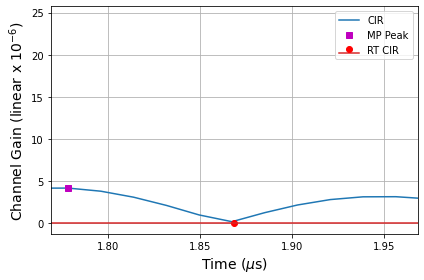

RT CIR at 1.5883740499999703 us is 6.776571428531497 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.66
Scaled RT CIR amplitude: 14.673
fig_num: 140


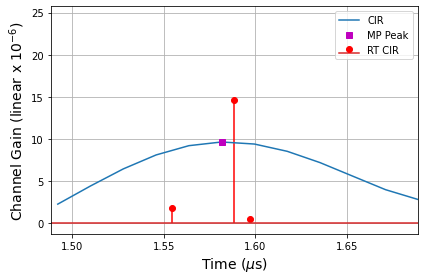

RT CIR at 1.5547010500000056 us is 26.896428571433262 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.66
Scaled RT CIR amplitude: 1.84
fig_num: 141


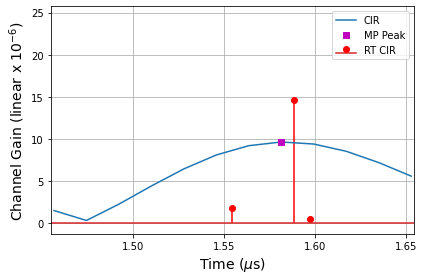

RT CIR at 1.5971570499999928 us is 15.559571428553909 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.66
Scaled RT CIR amplitude: 0.52
fig_num: 142


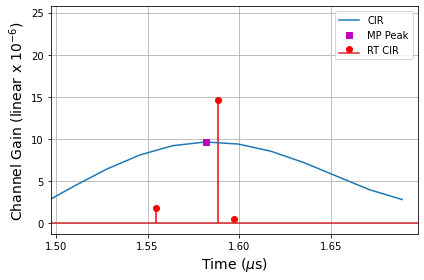

RT CIR at 0.778026049999994 us is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 24.507
Scaled RT CIR amplitude: 24.507

MATCH
fig_num: 143


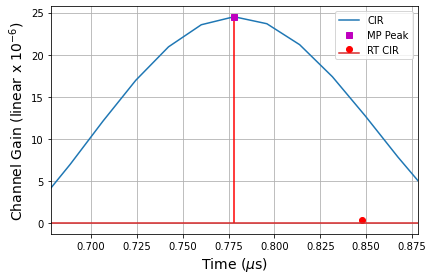

RT CIR at 0.8478070500000001 us is 69.78100000000609 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 24.507
Scaled RT CIR amplitude: 0.405
fig_num: 144


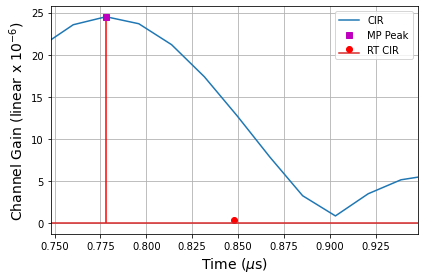

RT CIR at 1.7276710499999695 us is 50.355000000024575 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.194
Scaled RT CIR amplitude: 0.301
fig_num: 145


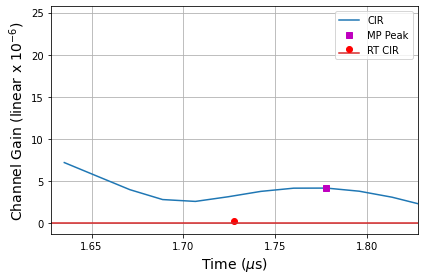

RT CIR at 1.043115049999983 us is 86.51757142854422 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.783
Scaled RT CIR amplitude: 0.678
fig_num: 146


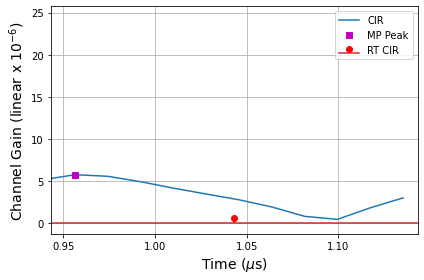

Number of total RT multipath: 12
Number of Non-matching RT multipath: 60
Number of RT multipath close in time (ns): 8
Number of Matching RT multipath (time and amplitude): 1

Pre-peak bucket matches: 0/5 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/6 --> 0.0% match rate

 ----- PLOTNUM: 19, TX: cnode-moran-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 

moran-guesthouse
RX Time Delay: 250.67857142857144 us
Amplitude matching adjustment ratio [xcorr/RT]: 19.83573612142988
fig_num: 147


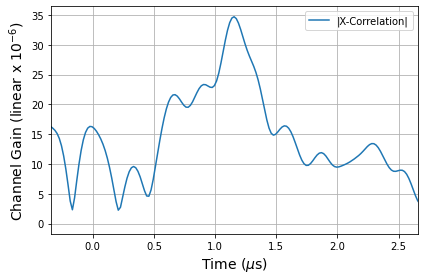

fig_num: 148


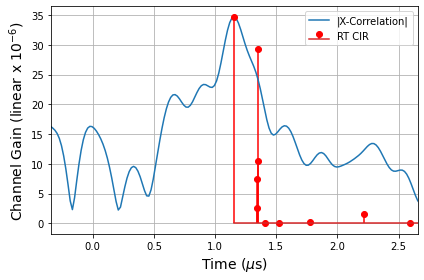

Count of measured local CIR peaks (pre-peak bucket): 3
Count of measured local CIR peaks (surrounding-peak bucket): 1
Count of measured local CIR peaks (post-peak bucket): 2
fig_num: 149


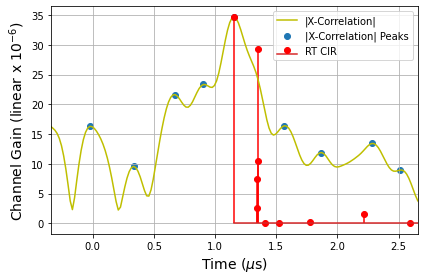

fig_num: 150


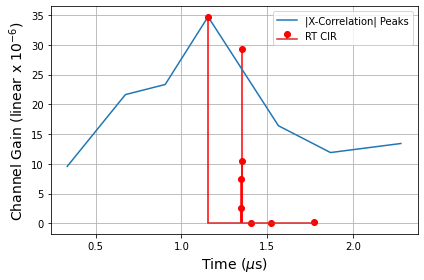

-- Total Received Power --
RT: 2231.0041135832853 W
CIR (local peaks): 2900.117385329728 W
CIR (full): 6920273.179494559 W
[0.33359983 0.67288554 0.9050284  1.1550284  1.56574269 1.86931411
 2.2800284 ]

-- RMS Delay Spread --
RT: 0.09889203781754935 us
CIR (local peaks): 0.43568305443087535 us
noise_std threshold: 23.03514986458817
Number of total RT multipath: 6
Number of Non-matching RT multipath: 51
Number of RT multipath close in time (ns): 0
Number of Matching RT multipath (time and amplitude): 0

Pre-peak bucket matches: 0/3 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/1 --> 0.0% match rate
Post-peak bucket matches: 0/2 --> 0.0% match rate
Results File Written.


In [8]:
# Cross Correlation & Delays

fig_num = 0

# matching x axis
def xaxis_match(oldx, peak, oldy):
    my = oldy.index(max(oldy))
    newx = [(x - oldx[my] + peak) for x in oldx]
    return newx

def yaxis_match(oldy, lagIndex_us, peak):
    old_peak = oldy[lagIndex_us]
    if old_peak == 0:
        old_peak = 1
    newy = [y * (peak/old_peak) for y in oldy]
    return newy, (peak/old_peak)

# Finding peak in area around RT multipath
def find_multipath_peak(local_cir):
    len_local = len(local_cir)
    
    for i in range(len_local):
        larger_than_prev = False
        larger_than_post = False
        
        if (i > 0) and (local_cir[i] >= local_cir[i-1]):
            larger_than_prev = True
        if (i < len_local - 1) and (local_cir[i] >= local_cir[i+1]):
            larger_than_post = True
        
        if larger_than_prev and larger_than_post:
            return i # index of peak element

def find_nearest_element(local_cir, value):
    local_cir = np.asarray(local_cir)
    near_ind = (np.abs(local_cir - value)).argmin()
    return near_ind

amp_ratios = []
total_peaks = []
match_percentages = []
total_peak = 0
total_match = 0
totalrpower = []
totalrmsdelay = []
RTrms_array = []
CIRrms_array = []
RTmeandel_array = []
CIRmeandel_array = []
RTpower_array = []
CIRpower_array = []
prebuckets = []
surbuckets = []
postbuckets = []
total_pre = 0
total_sur = 0
total_post = 0
total_pre_match = 0
total_sur_match = 0
total_post_match = 0
pre_match_array = []
sur_match_array = []
post_match_array = []
plotnum = 0

### CIR ANALYSIS FOR ALL LINKS IN DATA -- LOOP ###

for tx in txlocs:
    for rx in rxlocs:
        if tx != rx:
            for repNum in range(rxrepeat):
                txloc = tx
                rxloc = rx
                
                print('\n ----- PLOTNUM: ' + str(plotnum) + ', TX: ' + txloc + ', RX: ' + rxloc + ' ----- \n')

                rx_data[txloc] = np.vstack(rx_data[txloc])
                rxloc_arr = np.array(txrxloc[txloc])
                rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]

                # Low Pass Filtering to out_of_band frequency components
                stopband_attenuation = 60.0
                transition_bandwidth = 0.05
                cutoff_norm = 0.15
                filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
                taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
                filtered_rx0 = signal.lfilter(taps, 1.0, rx0)

                packetSignal = QPSK_samples
                lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, packetSignal)
                plotnum += 1
                
                # Find associated RT results in JSON
                tname = txloc.split('-')[1]
                rname = rxloc.split('-')[1]
                pairname = tname + '-' + rname
                print(pairname)
                
                print('RX Time Delay: ' + str(samples_to_us(lagIndex,samp_rate)) + ' us')
                
                lagIndex_us = samples_to_us(lagIndex,samp_rate)
                lags_us = ((lags/samp_rate)*1000000)
                
                #RT CIR results
                f_rttau = rt_json[pairname][0] #x
                f_rta = rt_json[pairname][1] #y

                # time of arrival of max amplitude RT peak
                toa_tau = f_rttau[f_rta.index(max(f_rta))] * 1000000
                
                #RT results from seconds to us to match CIR plot
                tau = [x * 100000000 for x in f_rttau]
                a = [x * 1000000 for x in f_rta] # change yaxis labels to be x10^-6

                peak_ind = lagIndex
                tau_plot = xaxis_match(tau, lagIndex_us, a)
                
                # time adjustment again to match RT peaks
                xdiff = tau_plot[a.index(max(a))] - toa_tau
                tau_plot = [t - xdiff for t in tau_plot] # in seconds
                lags_us = lags_us - xdiff
                lagIndex_us = toa_tau
                
                xcorr_mag, amp_ratio = yaxis_match(xcorr_mag, np.where(lags == lagIndex)[0][0], max(a))
                a_plot = a
                
                amp_ratios.append(amp_ratio)
                print('Amplitude matching adjustment ratio [xcorr/RT]: ' + str(amp_ratio))

                # figure 4 plot
                plt.figure()
                plt.plot(lags_us, xcorr_mag, label='|X-Correlation|')
                plt.legend(loc='upper right')
                # plt.title(f'Peak at {(lagIndex_us*1000):.4f} ns')
                plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.xlim((lagIndex_us-1.5,lagIndex_us+1.5))
                plt.tight_layout()
                plt.grid(True)
                fname = f'{fig_num}.pdf'
                plt.savefig(fname)
                fig_num += 1
                print('fig_num: ' + str(fig_num))
                plt.show()
                
                plt.figure()
                plt.plot(lags_us, xcorr_mag, label='|X-Correlation|')
                plt.stem(tau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                plt.legend(loc='upper right')
                # plt.title(f'Peak at {(lagIndex_us*1000):.4f} ns')
                plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.xlim((lagIndex_us-1.5,lagIndex_us+1.5))
                plt.tight_layout()
                plt.grid(True)
                fname = f'{fig_num}.pdf'
                plt.savefig(fname)
                fig_num += 1
                print('fig_num: ' + str(fig_num))
                plt.show()

                # Calculations & Plots for Total Received Power and RMS Delay Spread

                #finding local peaks for measured CIR
                peak_indicies, _ = find_peaks(xcorr_mag)
                peaks = []
                peaks_lags = []
                for each in peak_indicies:
                    peaks.append(xcorr_mag[each])
                    peaks_lags.append(lags_us[each])
                peaks = np.array(peaks)
                peaks_lags = np.array(peaks_lags)

                # Local Peaks CIR Identified
                ## counting measured CIR peaks in pre-peak bucket
                start = True
                low_lim = lagIndex_us-1
                if low_lim < 0.0:
                    low_lim = 0.0
                up_lim = lagIndex_us-.1
                for i, each in enumerate(peaks_lags):
                    if each > low_lim and start:
                        low_ind = i
                        start = False
                    if each > up_lim:
                        up_ind = i
                        break
                peaks_lags1 = peaks_lags[low_ind:up_ind]
                peaks1 = peaks[low_ind:up_ind]
                print(f'Count of measured local CIR peaks (pre-peak bucket): {len(peaks1)}')
                ## counting measured CIR peaks in surrounding peak bucket
                start = True
                low_lim = lagIndex_us-.1
                if low_lim < 0.0:
                    low_lim = 0.0
                up_lim = lagIndex_us+.1
                for i, each in enumerate(peaks_lags):
                    if each > low_lim and start:
                        low_ind = i
                        start = False
                    if each > up_lim:
                        up_ind = i
                        break
                peaks_lags2 = peaks_lags[low_ind:up_ind]
                peaks2 = peaks[low_ind:up_ind]
                print(f'Count of measured local CIR peaks (surrounding-peak bucket): {len(peaks2)}')
                ## counting measured CIR peaks in post-peak bucket
                start = True
                low_lim = lagIndex_us+.1
                if low_lim < 0.0:
                    low_lim = 0.0
                up_lim = lagIndex_us+1
                for i, each in enumerate(peaks_lags):
                    if each > low_lim and start:
                        low_ind = i
                        start = False
                    if each > up_lim:
                        up_ind = i
                        break
                peaks_lags3 = peaks_lags[low_ind:up_ind]
                peaks3 = peaks[low_ind:up_ind]
                print(f'Count of measured local CIR peaks (post-peak bucket): {len(peaks3)}')
                
                plt.figure()
                plt.plot(lags_us, xcorr_mag, 'y', label='|X-Correlation|')
                plt.scatter(peaks_lags, peaks, label='|X-Correlation| Peaks')
                plt.stem(tau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                plt.legend(loc='upper right')
                # plt.title(f'Peak at {(lagIndex_us*1000):.4f} ns')
                plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.xlim((lagIndex_us-1.5,lagIndex_us+1.5))
                plt.tight_layout()
                plt.grid(True)
                fname = f'{fig_num}.pdf'
                plt.savefig(fname)
                fig_num += 1
                print('fig_num: ' + str(fig_num))
                plt.show()

                # cropping to approximately 1us around peak of interest
                sindex = 0
                slook = True
                eindex = 0
                elook = False
                
                for index,value in enumerate(peaks_lags):
                    if value > (lagIndex_us-1) and slook:
                        sindex = index
                        slook = False
                        elook = True
                    if elook and value > (lagIndex_us+1):
                        eindex = index
                        break

                peaks_cropped = peaks[sindex:eindex+1]
                peaks_lags_cropped = peaks_lags[sindex:eindex+1]

                # cropping for RT 1us around peak of interest
                sindex = 0
                slook = True
                eindex = 0
                elook = False

                pairs_plot = []
                for index, value in enumerate(tau_plot):
                    pairs_plot.append([tau_plot[index], a_plot[index]])

                pairs_plot.sort(key=lambda tauele: tauele[0])
                a_plot_cropped = []
                tau_plot_cropped = []
                for each in pairs_plot:
                    tau_plot_cropped.append(each[0])
                    a_plot_cropped.append(each[1])
                tau_plot_cropped = np.array(tau_plot_cropped)
                a_plot_cropped = np.array(a_plot_cropped)

                for index,value in enumerate(tau_plot_cropped):
                    if value > (lagIndex_us-1) and slook:
                        sindex = index
                        slook = False
                        elook = True
                    if elook and value > (lagIndex_us+1):
                        eindex = index
                        break

                tau_plot_cropped = tau_plot_cropped[sindex:eindex]
                a_plot_cropped = a_plot_cropped[sindex:eindex]
                
                if len(tau_plot_cropped) == 0:
                    continue

                lags_cropped = peaks_lags_cropped
                tau_plot_cropped = tau_plot_cropped
                
                # Local Peaks CIR Identified & Cropped to approximately 1us around peak of interest
                plt.figure()
                plt.plot(lags_cropped, peaks_cropped, label='|X-Correlation| Peaks')
                plt.stem(tau_plot_cropped, a_plot_cropped, label='RT CIR', linefmt='r-', markerfmt='ro')
                plt.legend(loc='upper right')
                # plt.title(f'Peak at {(lagIndex_us*1000):.4f} ns')
                plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.tight_layout()
                plt.grid(True)
                fname = f'{fig_num}.pdf'
                plt.savefig(fname)
                fig_num += 1
                print('fig_num: ' + str(fig_num))
                plt.show()

                # Received Power Calculations (using cropped data)
                # P = sum[amplitudes]^2
                cir_power_peaks = 0
                cir_power = 0
                rt_power = 0
                for each in peaks_cropped:
                    cir_power_peaks += (each**2)
                for each in xcorr_mag:
                    cir_power += (each**2)
                for each in a_plot_cropped:
                    rt_power += (each**2)

                print('-- Total Received Power --')
                print('RT: ' + str(rt_power) + ' W')
                print('CIR (local peaks): ' + str(cir_power_peaks) + ' W')
                print('CIR (full): ' + str(cir_power) + ' W')
#                 print('RT: ' + str(round(rt_power,2)) + ' W')
#                 print('CIR (local peaks): ' + str(round(cir_power_peaks,2)) + ' W')
#                 print('CIR (full): ' + str(round(cir_power,2)) + ' W')
                
                # (CIR local peaks, RT)
#                 totalrpowerstr = '(' + str(round(cir_power_peaks,2)) + ' W, ' + str(round(rt_power,2)) + ' W)'
                totalrpowerstr = '(' + str(cir_power_peaks) + ' W, ' + str(rt_power) + ' W)'
                totalrpower.append(totalrpowerstr)
                
                RTpower_array.append(rt_power)
                CIRpower_array.append(cir_power_peaks)

                # RMS Delay Spread Calculations (using cropped data)
                # \tau_{rms} = \sqrt{\frac{\sum{P_h(\tau)*\tau^2}}{\sum{P_h(\tau)}} - 
                #                   (\frac{\sum{P_h(\tau)*\tau}}{\sum{P_h(\tau)}})^2}

                #cir calculation
                print(lags_cropped)
                tlags_cropped = lags_cropped #- lags_cropped[0]
                num1 = 0
                denom = 0
                num2 = 0
                for i,p in enumerate(peaks_cropped):
                    powerht = p**2

                    num1 += powerht*tlags_cropped[i]
                    denom += powerht

                    num2 += powerht*(tlags_cropped[i]**2)

                tau_mean = num1/denom
                tau_bar_sq = num2/denom
                CIRtrms = math.sqrt(tau_bar_sq - (tau_mean**2))
                
                CIRmeandel_array.append(tau_mean)

                #rt calculation
                ttau_plot_cropped = tau_plot_cropped #- tau_plot_cropped[0]
                num1 = 0
                denom = 0
                num2 = 0
                for i,p in enumerate(a_plot_cropped):
                    powerht = p**2

                    num1 += powerht*ttau_plot_cropped[i]
                    denom += powerht

                    num2 += powerht*(ttau_plot_cropped[i]**2)

                tau_mean = num1/denom
                tau_bar_sq = num2/denom
                RTtrms = math.sqrt(tau_bar_sq - (tau_mean**2))
                
                RTmeandel_array.append(tau_mean)

                print('\n-- RMS Delay Spread --')
                print('RT: ' + str(RTtrms) + ' us')
                print('CIR (local peaks): ' + str(CIRtrms) + ' us')
                
                CIRrms_array.append(CIRtrms)
                RTrms_array.append(RTtrms)
                
                # (CIR local peaks, RT)
                totalrmsdelaystr = '(' + str(CIRtrms) + ' us, ' + str(RTtrms) + ' us)'
                totalrmsdelay.append(totalrmsdelaystr)

                # Calculating noise floor for link

                noise_buffer = 25
                noise_arr = np.concatenate((xcorr_mag[:peak_ind-noise_buffer], xcorr_mag[peak_ind+noise_buffer:]))

                second_peak = max(noise_arr)
                second_peak_ind = np.where(noise_arr == second_peak)[0][0]

                noisearr = np.concatenate((noise_arr[:second_peak_ind-noise_buffer], noise_arr[second_peak_ind+noise_buffer:]))

                noise_std = np.std(noisearr)
                noise_std_thresh = 3.4*np.sqrt(2)*noise_std

#                 plt.figure()
#                 plt.plot(lags_us, xcorr_mag, label='|X-Correlation|')
#                 plt.axhline(y = noise_std_thresh, color = 'r', linestyle = '-', label='Noise Floor Threshold')
#                 plt.legend(loc='upper right')
#                 plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
#                 plt.xlabel(r'Time ($\mu$s)', fontsize=14)
#                 plt.xticks(fontsize=10)
#                 plt.yticks(fontsize=10)
#                 plt.tight_layout()
#                 plt.grid(True)
#                 plt.show()

                print('noise_std threshold: ' + str(noise_std_thresh))

                # peak finding algorithm
                stau = find_nearest_element(lags_us, tau_plot[0])
                cir_cropped = xcorr_mag[stau:]
                lags_cropped = lags_us[stau:]
                limit = 0.1 # 100ns in us

                a_ind = 0
                non_match_count = 0
                match_count = 0
                ns_match_count = 0
                
                # buckets for matching peaks
                prebucket_count = 0
                surbucket_count = 0
                postbucket_count = 0
                
                prebucket_match = 0
                surbucket_match = 0
                postbucket_match = 0
                
                lowerbucket_lim = lagIndex_us - 0.1
                upperbucket_lim = lagIndex_us + 0.1
                
                for each in a_plot:
                    bucket = 0
                    lower_near_ind = find_nearest_element(lags_cropped, tau_plot[a_ind]-limit)
                    upper_near_ind = find_nearest_element(lags_cropped, tau_plot[a_ind]+limit)
                    cir_plot = cir_cropped[lower_near_ind:upper_near_ind+1]
                    lags_plot = lags_cropped[lower_near_ind:upper_near_ind+1]
                    
                    # checking bucket
                    if tau_plot[a_ind] <= lowerbucket_lim:
                        bucket = 1
                        prebucket_count += 1
                    elif tau_plot[a_ind] >= upperbucket_lim:
                        bucket = 3
                        postbucket_count += 1
                    else:
                        bucket = 2
                        surbucket_count += 1
                        
                    local_peak_ind = find_multipath_peak(cir_plot)
                    if (local_peak_ind != None) and (cir_plot[local_peak_ind] >= noise_std_thresh):
                        peak_diff = abs(lags_plot[local_peak_ind]-tau_plot[a_ind])*1000 # in ns
                        print(r'RT CIR at ' + str(tau_plot[a_ind]) + ' us is ' + str(peak_diff) + ' ns away from measured multipath peak.')
                        if peak_diff <= 100: #if peaks within 100 ns of each other
                            print('Measured Multipath Peak amplitude: ' + str(round(cir_plot[local_peak_ind],3)))
                            print('Scaled RT CIR amplitude: ' + str(round(a_plot[a_ind],3)))

                            sm_peak = min(cir_plot[local_peak_ind], a_plot[a_ind])
                            if abs(cir_plot[local_peak_ind]-a_plot[a_ind]) <= (0.5*sm_peak):
                                print('\nMATCH')
                                match_count += 1
                                
                                if bucket == 1:
                                    prebucket_match += 1
                                elif bucket == 2:
                                    surbucket_match += 1
                                elif bucket == 3:
                                    postbucket_match += 1
                                else:
                                    print(' -- Match in invalid bucket. -- ')

                            plt.figure()
                            plt.plot(lags_plot, cir_plot, label='CIR')
                            plt.stem(tau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                            plt.plot(lags_plot[local_peak_ind], cir_plot[local_peak_ind], 'ms', label='MP Peak') #linefmt='m-', markerfmt='ms'
                            plt.legend(loc='upper right')
                            plt.ylabel(r'Channel Gain (linear x $10^{-6}$)', fontsize=14)
                            plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                            plt.xlim((tau_plot[a_ind]-limit,tau_plot[a_ind]+limit))
                            plt.xticks(fontsize=10)
                            plt.yticks(fontsize=10)
                            plt.tight_layout()
                            # plt.ylim((0,10))
                            plt.grid(True)
                            fname = f'{fig_num}.pdf'
                            plt.savefig(fname)
                            fig_num += 1
                            print('fig_num: ' + str(fig_num))
                            plt.show()
                            
                            ns_match_count += 1
                    else:
                        non_match_count += 1

                    a_ind += 1
                
                prebucket_count = len(peaks1)
                surbucket_count = len(peaks2)
                postbucket_count = len(peaks3)
                total_measured_local_peaks = prebucket_count + surbucket_count + postbucket_count
                
                print('Number of total RT multipath: ' + str(total_measured_local_peaks)) #a_ind))
                print('Number of Non-matching RT multipath: ' + str(non_match_count))
                print('Number of RT multipath close in time (ns): ' + str(ns_match_count))
                print('Number of Matching RT multipath (time and amplitude): ' + str(match_count) + '\n')
                
                if prebucket_count != 0:
                    print('Pre-peak bucket matches: ' + str(prebucket_match) + '/' + str(prebucket_count) + ' --> ' + str((prebucket_match/prebucket_count)*100) + '% match rate')
                else:
                    print(str(prebucket_count) + ' pre-peak bucket peak matches.')
                prebuckets.append(str(prebucket_match) + '/' + str(prebucket_count))
                    
                if surbucket_count != 0:
                    print(r'Peak bucket matches (within 0.2 microseconds of peak): ' + str(surbucket_match) + '/' + str(surbucket_count) + ' --> ' + str((surbucket_match/surbucket_count)*100) + '% match rate')
                else:
                    print(str(surbucket_count) + r' peak bucket peak matches within 0.2 microseconds of peak.')
                surbuckets.append(str(surbucket_match) + '/' + str(surbucket_count))
                
                if postbucket_count != 0:
                    print('Post-peak bucket matches: ' + str(postbucket_match) + '/' + str(postbucket_count) + ' --> ' + str((postbucket_match/postbucket_count)*100) + '% match rate')
                else:
                    print(str(postbucket_count) + ' post-peak bucket peak matches.')
                postbuckets.append(str(postbucket_match) + '/' + str(postbucket_count))
                
                total_peaks.append(total_measured_local_peaks) #a_ind)
                match_percentage = match_count / total_measured_local_peaks #a_ind
                match_percentages.append(round(match_percentage * 100, 4))
                total_peak += total_measured_local_peaks #a_ind
                total_match += match_count
                #bucket data
                total_pre_match += prebucket_match
                total_sur_match += surbucket_match
                total_post_match += postbucket_match
                pre_match_array.append(prebucket_match)
                sur_match_array.append(surbucket_match)
                post_match_array.append(postbucket_match)
                total_pre += prebucket_count
                total_sur += surbucket_count
                total_post += postbucket_count
                

ratiostr = ''
for each in amp_ratios:
    ratiostr += str(each) + '\n'
    
powerstr = ''
for each in totalrpower:
    powerstr += str(each) + '\n'

rmsstr = ''
for each in totalrmsdelay:
    rmsstr += str(each) + '\n'

prestring = '['
for each in prebuckets:
    prestring += str(each) + ', '
prestring = prestring[:-2] + ']'

surstring = '['
for each in surbuckets:
    surstring += str(each) + ', '
surstring = surstring[:-2] + ']'

poststring = '['
for each in postbuckets:
    poststring += str(each) + ', '
poststring = poststring[:-2] + ']'

with open('results.txt','w') as file:
    file.write('Result Statistics Per Link:')
    file.write('\nTotal Peaks per link: ')
    file.writelines(str(total_peaks))
    file.write('\nPeak Match Percentages per link [%]: ')
    file.writelines(str(match_percentages))
    file.write('\n\nTotal Result Statistics:')
    file.write('\nTotal Peaks: ' + str(total_peak) + ', Total Matches: ' + str(total_match))
    file.write('\nTotal Match Percentage: ' + str(round((total_match / total_peak) * 100, 4)) + '%')
    file.write('\n\nAmplitude Adjustment Ratios per link:\n')
    file.write(ratiostr)
    file.write('\nTotal Received Power per link [(CIR local peaks, RT)]:\n')
    file.write(powerstr)
    file.write('\nRMS Delay Spread per link [(CIR local peaks, RT)]:\n')
    file.write(rmsstr)
    file.write('\nBucket Peak Matching Data:')
    file.write('\nTotal Pre-peak Peak Matches: ' + str(total_pre_match) + '/' + str(total_pre))
    file.write('\nTotal Surrounding Peak Matches (within 0.2 microseconds of peak): ' + str(total_sur_match) + '/' + str(total_sur))
    file.write('\nTotal Post-peak Peak matches: ' + str(total_post_match) + '/' + str(total_post))
    file.write('\n\nBucket Peak Matching per link:')
    file.write('\nPre-peak matches: ')
    file.write(prestring)
    file.write('\nSurronding peak matches (within 0.2 microseconds): ')
    file.write(surstring)
    file.write('\nPost-peak matches: ')
    file.write(poststring)

print('Results File Written.')

r correlation for RMS delay spread: -0.34970110335490917
fig_num: 151


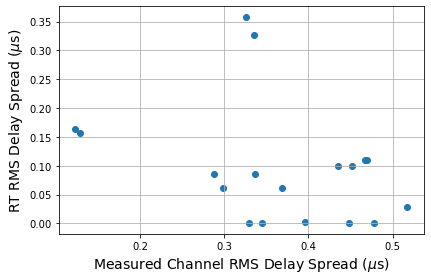

r correlation for mean delay: 0.9972661341058195
fig_num: 152


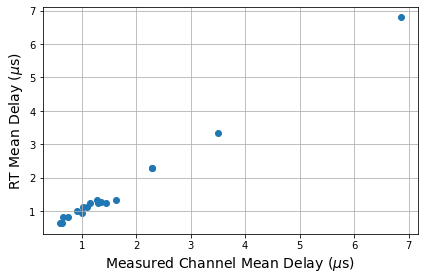

r correlation for average received power: 0.8517902112512272
fig_num: 153


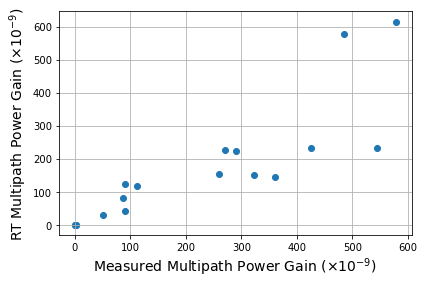

In [9]:
# scatter plots: 

# RMS delay spread

RTrms_array = np.array(RTrms_array)
CIRrms_array = np.array(CIRrms_array)

# calculate r correlation coefficient
corrmat = np.corrcoef(CIRrms_array, RTrms_array)
r_value = corrmat[0, 1]
print(f'r correlation for RMS delay spread: {r_value}')

plt.figure()
plt.scatter(CIRrms_array, RTrms_array)
plt.xlabel(r'Measured Channel RMS Delay Spread ($\mu$s)', fontsize=14)
plt.ylabel(r'RT RMS Delay Spread ($\mu$s)', fontsize=14)
#plt.title(r'RMS Delay Spread Per Link - Measured vs. RT in $\mu$s')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(True)
fname = f'{fig_num}.pdf'
plt.savefig(fname)
fig_num += 1
print('fig_num: ' + str(fig_num))
plt.show()

# mean delay

RTmeandel_array = np.array(RTmeandel_array)
CIRmeandel_array = np.array(CIRmeandel_array)

# calculate r correlation coefficient
corrmat = np.corrcoef(CIRmeandel_array, RTmeandel_array)
r_value = corrmat[0, 1]
print(f'r correlation for mean delay: {r_value}')

plt.figure()
plt.scatter(CIRmeandel_array, RTmeandel_array)
plt.xlabel(r'Measured Channel Mean Delay ($\mu$s)', fontsize=14)
plt.ylabel(r'RT Mean Delay ($\mu$s)', fontsize=14)
#plt.title(r'Mean Delay Per Link - Measured vs. RT in $\mu$s')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(True)
fname = f'{fig_num}.pdf'
plt.savefig(fname)
fig_num += 1
print('fig_num: ' + str(fig_num))
plt.show()

# # pre-peak histogram
# pre_match_array = np.array(pre_match_array)

# plt.figure()
# plt.hist(pre_match_array)
# plt.xlabel('Number of Pre-Peak Matching Multipath Per link', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Pre-Peak Matches Across Links')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()
# plt.grid(False)
# plt.show()

# # surrounding-peak histogram
# sur_match_array = np.array(sur_match_array)

# plt.figure()
# plt.hist(sur_match_array)
# plt.xlabel('Number of Surrounding-Peak Matching Multipath Per link', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Surrounding-Peak Matches Across Links')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()
# plt.grid(False)
# plt.show()

# # post-peak histogram
# post_match_array = np.array(post_match_array)

# plt.figure()
# plt.hist(post_match_array)
# plt.xlabel('Number of Post-Peak Matching Multipath Per link', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.title('Post-Peak Matches Across Links')
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()
# plt.grid(False)
# plt.show()

# average received power

RTpower_array = np.array(RTpower_array) * 0.1 # factor of 10^{-10} with W and then convert to nW
CIRpower_array = np.array(CIRpower_array) * 0.1

# calculate r correlation coefficient
corrmat = np.corrcoef(CIRpower_array, RTpower_array)
r_value = corrmat[0, 1]
print(f'r correlation for average received power: {r_value}')

plt.figure()
plt.scatter(CIRpower_array, RTpower_array)
plt.xlabel(r'Measured Multipath Power Gain ($\times 10^{-9}$)', fontsize=14)
plt.ylabel(r'RT Multipath Power Gain ($\times 10^{-9}$)', fontsize=14)
#plt.title(r'Average Received Power Per Link - Measured vs. RT in nW')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.grid(True)
fname = f'{fig_num}.pdf'
plt.savefig(fname)
fig_num += 1
print('fig_num: ' + str(fig_num))
plt.show()

In [10]:
print('Done.')

Done.
